# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt17_raw/ggH_bbtt*.root', 'root_raw/mt17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt16_raw/ggH_bbtt*.root', 'root_raw/mt16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 2b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.2770')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3033')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3093')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_2,beta_deepflavour_2,bphi_deepflavour_2,bm_deepflavour_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
m_b2mu = '(mymu+myb2).M()'
m_b2tau = '(mytau+myb2).M()'
m_bbmu = '(myb1+myb2+mymu).M()'
m_bbtau = '(myb1+myb2+mytau).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b2mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb2)'
dR_b2tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbmu = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mymu)'
dR_bbtau = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mytau)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'

tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files17[i] = files17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files16[i] = files16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 mu+tau trigger requirements
trigger24OR27_18 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_18 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS_18 = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_18 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb_18 = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_18 = trigger24OR27_18 + str(' or ') + trigger2027HPS_18
trigger_obs_1_18 = trigger2027_18 + str(' or ') + trigger24OR27_18
trigger_obs_2_18 = trigger2027HPS_18 + str(' or ') + trigger24OR27_18
trigger_emb_18 = trigger24OR27_emb_18 + str(' or ') + trigger2027HPS_emb_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files18[1] = files18[1].Filter('gen_match_1==4 && gen_match_2==5')#reconstructed taus are gen taus
files18[1] = files18[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger24OR27_17 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_17 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_17 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_emb_17 = '(matchEmbFilter_Mu20Tau27_2017_1 && matchEmbFilter_Mu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger24OR27_17 + str(' or ') + trigger2027_17
trigger_emb_17 = trigger24OR27_emb_17 + str(' or ') + trigger2027_emb_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files17[1] = files17[1].Filter('gen_match_1==4 && gen_match_2==5')#reconstructed taus are gen taus
files17[1] = files17[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger22_16 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or (passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or (passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or (passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920_16 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1) or (passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1))'

trigger_all_16 = trigger22_16 + str(' or ') + trigger1920_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files16[1] = files16[1].Filter('gen_match_1==4 && gen_match_2==5')#reconstructed taus are gen taus
files16[1] = files16[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1mu', 'm_b1tau', 'm_b2mu', 'm_b2tau', 'dm_a',\
                'm_bbmu', 'm_bbtau', 'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b2mu', 'dR_b2tau', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbmu','dR_bbtau', 'mT_mu', 'mT_tau', 'mT_b1', 'mT_b2', 'Dzeta',\
                'bpt_deepflavour_1', 'bpt_deepflavour_2']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (10003, 30)
ZTT18.shape  : (34109, 30)
TT18.shape   : (522337, 30)
qcd18_1.shape: (24022, 30)
qcd18_2.shape: (54127, 30)

sig17.shape  : (10055, 30)
ZTT17.shape  : (23387, 30)
TT17.shape   : (76816, 30)
qcd17.shape  : (53045, 30)

sig16.shape  : (8663, 30)
ZTT16.shape  : (15529, 30)
TT16.shape   : (471133, 30)
qcd16.shape  : (38298, 30)

sig_allyears.shape: (28721, 31)
ZTT_allyears.shape: (73025, 31)
TT_allyears.shape : (1070286, 31)
qcd_allyears.shape: (169492, 31)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 1781, random_state = 20)#6.2%
TT_allyears = TT_allyears.sample(n = 19674, random_state = 20)#68.5%
qcd_allyears = qcd_allyears.sample(n = 7266, random_state = 20)#25.3%

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
             pt_1      m_b1tt      m_b2tt      m_bbtt        m_bb      m_b1mu  \
0       25.363937  105.477096   78.401811  134.938054   35.345804   64.292431   
1       31.467047   87.381220   73.276306  113.254970   15.609270   63.118108   
2       28.183609   95.799115  104.848260  145.342437   38.045337   60.483321   
3       29.640209   95.904917   80.578863  130.243087   41.273101   76.357755   
4       24.527584   70.262660   84.775273  110.633512   22.470288   53.770041   
...           ...         ...         ...         ...         ...         ...   
20758  101.924828  266.023964  402.790098  474.697310   93.080413  228.615899   
11665   94.911453  399.117332  195.936642  484.474129  239.691397  277.359210   
34934   40.575661  251.318070  174.676250  359.477355  223.256229  191.598160   
48643  120.961571  675.545911  729.088094  759.801741   93.271588  133.194958   
23916   97.393845  173.122973  159.647135  260.141184  141.206792  117.075048   

          m

## Compare input feature distributions between sig and bkg

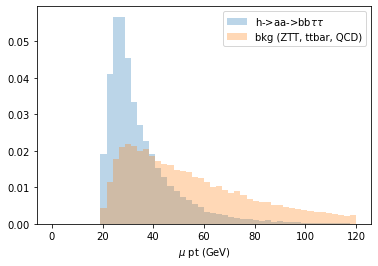

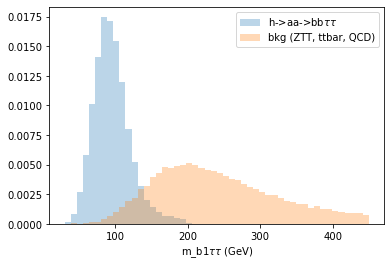

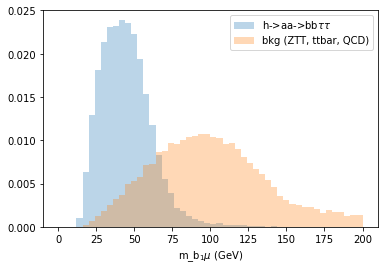

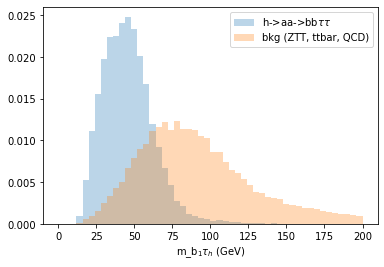

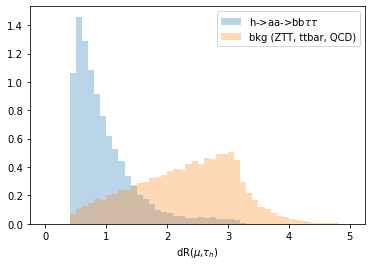

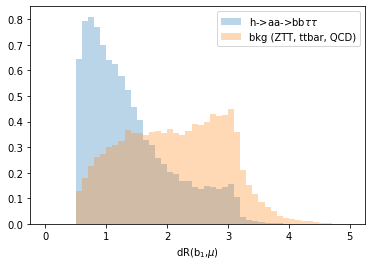

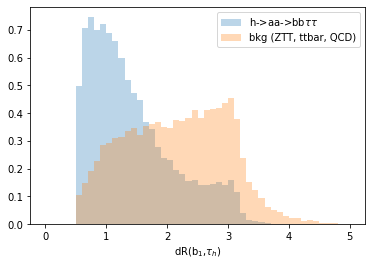

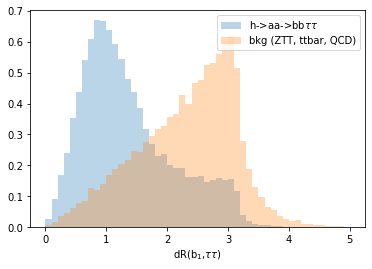

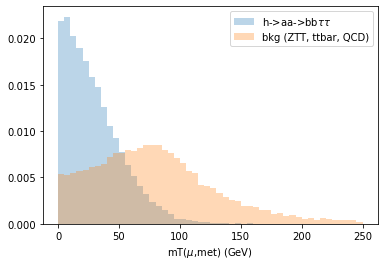

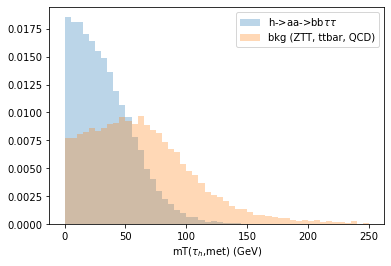

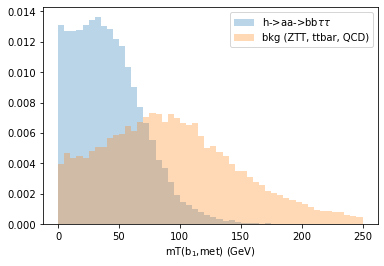

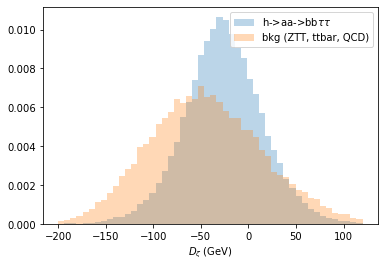

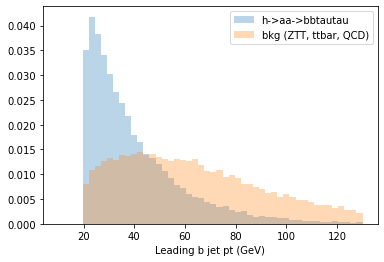

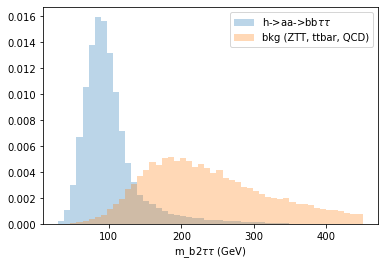

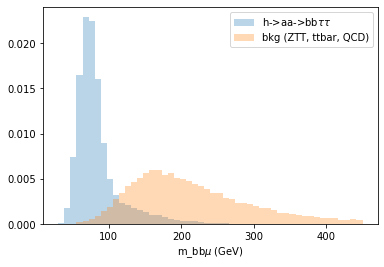

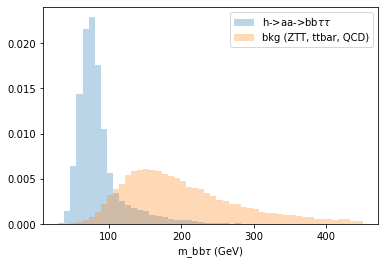

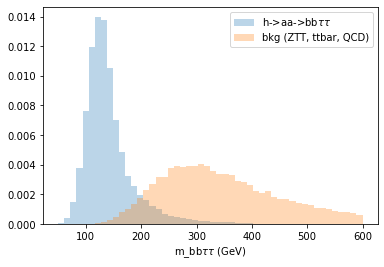

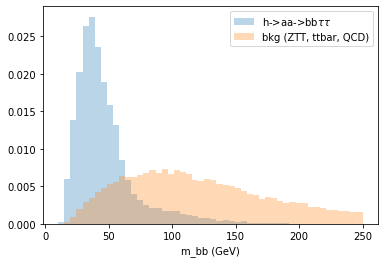

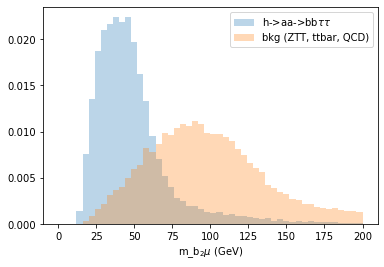

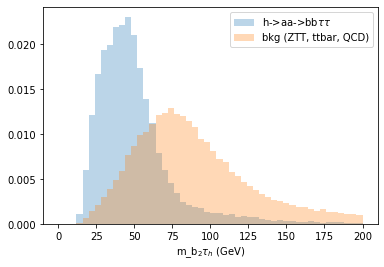

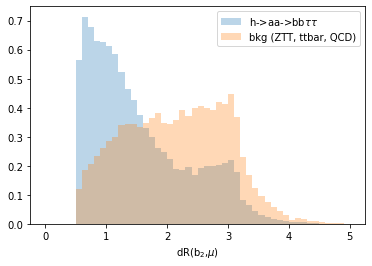

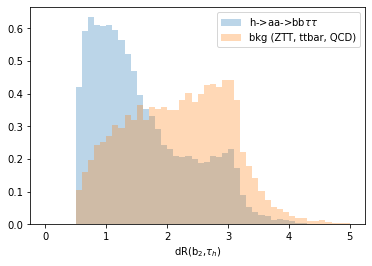

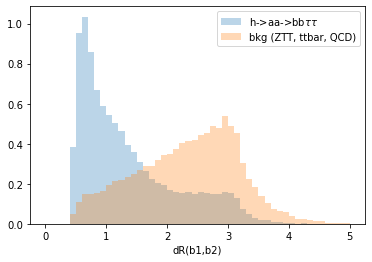

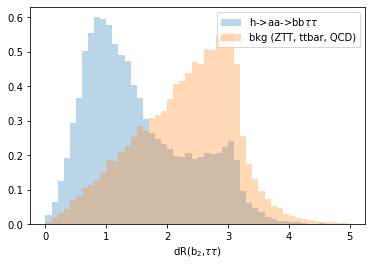

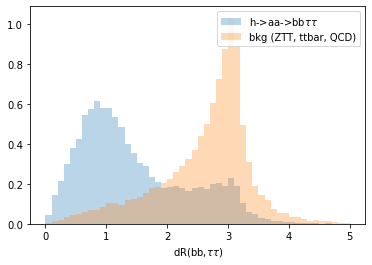

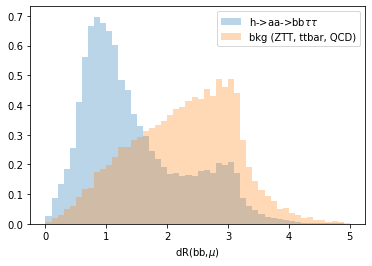

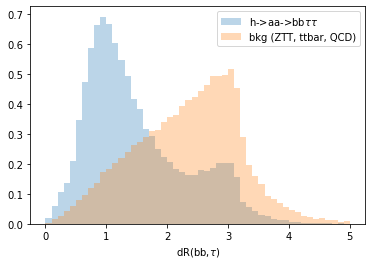

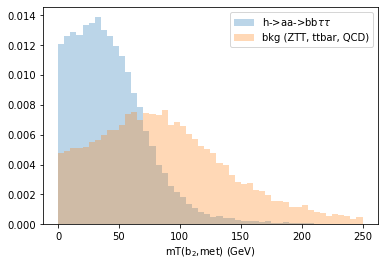

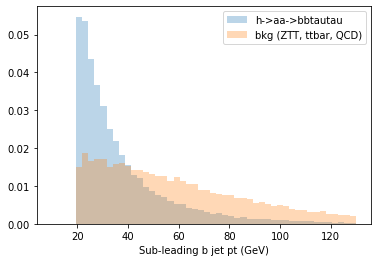

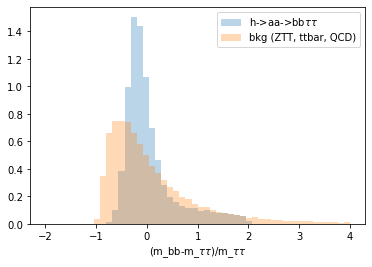

"\npyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')\npyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')\n#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')\n#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')\n#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')\npyplot.legend(loc = 'upper right')\npyplot.xlabel('$\\tau\\tau$ pt (GeV)')\npyplot.show()\n\npyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')\npyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')\n#pyplot.hist(ZTT_allyears['tt_eta'], den

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

############## for 2b events
pyplot.hist(sig_allyears['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()



'''
pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()
'''

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.50/0.25/0.25
X_train.shape: (28720, 30)
Y_train.shape: (28720, 1)
X_val.shape: (14361, 30)
Y_val.shape: (14361, 1)
X_test.shape: (14361, 30)
Y_test.shape: (14361, 1)

Total number of sig/bkg examples: 28721/28721 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 14288/14432 (49.7%/50.3%)
val   : 7222/7139 (50.3%/49.7%)
test  : 7211/7150 (50.2%/49.8%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-08-28 00:10:31.981328: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-28 00:10:31.982764: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 128)

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 2:45 - loss: 0.7311 - accuracy: 0.47 - ETA: 17s - loss: 0.6090 - accuracy: 0.6867 - ETA: 9s - loss: 0.5290 - accuracy: 0.760 - ETA: 6s - loss: 0.4686 - accuracy: 0.80 - ETA: 4s - loss: 0.4204 - accuracy: 0.82 - ETA: 3s - loss: 0.3819 - accuracy: 0.84 - ETA: 3s - loss: 0.3472 - accuracy: 0.86 - ETA: 2s - loss: 0.3254 - accuracy: 0.87 - ETA: 2s - loss: 0.3023 - accuracy: 0.88 - ETA: 2s - loss: 0.2880 - accuracy: 0.88 - ETA: 1s - loss: 0.2774 - accuracy: 0.89 - ETA: 1s - loss: 0.2639 - accuracy: 0.89 - ETA: 1s - loss: 0.2520 - accuracy: 0.90 - ETA: 1s - loss: 0.2417 - accuracy: 0.90 - ETA: 1s - loss: 0.2327 - accuracy: 0.91 - ETA: 1s - loss: 0.2240 - accuracy: 0.91 - ETA: 0s - loss: 0.2162 - accuracy: 0.91 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - ETA: 0s - loss: 0.2046 - accuracy: 0.92 - ETA: 0s - loss: 0.1992 - accuracy: 0.92 - ETA: 0s - loss: 0.1939 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7719 - accuracy: 0.56 - ETA: 9s - loss: 0.7321 - accuracy: 0.5677 - ETA: 5s - loss: 0.6453 - accuracy: 0.64 - ETA: 3s - loss: 0.5756 - accuracy: 0.70 - ETA: 3s - loss: 0.5263 - accuracy: 0.73 - ETA: 2s - loss: 0.4872 - accuracy: 0.76 - ETA: 2s - loss: 0.4497 - accuracy: 0.78 - ETA: 1s - loss: 0.4238 - accuracy: 0.80 - ETA: 1s - loss: 0.4021 - accuracy: 0.81 - ETA: 1s - loss: 0.3802 - accuracy: 0.82 - ETA: 1s - loss: 0.3629 - accuracy: 0.83 - ETA: 1s - loss: 0.3510 - accuracy: 0.84 - ETA: 1s - loss: 0.3384 - accuracy: 0.85 - ETA: 0s - loss: 0.3261 - accuracy: 0.85 - ETA: 0s - loss: 0.3138 - accuracy: 0.86 - ETA: 0s - loss: 0.3036 - accuracy: 0.86 - ETA: 0s - loss: 0.2940 - accuracy: 0.87 - ETA: 0s - loss: 0.2848 - accuracy: 0.87 - ETA: 0s - loss: 0.2768 - accuracy: 0.88 - ETA: 0s - loss: 0.2703 - accuracy: 0.88 - ETA: 0s - loss: 0.2635 - accuracy: 0.88 - ETA: 0s

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 2:08 - loss: 0.6712 - accuracy: 0.53 - ETA: 15s - loss: 0.5999 - accuracy: 0.6076 - ETA: 8s - loss: 0.5320 - accuracy: 0.702 - ETA: 5s - loss: 0.4761 - accuracy: 0.76 - ETA: 4s - loss: 0.4335 - accuracy: 0.79 - ETA: 3s - loss: 0.3930 - accuracy: 0.81 - ETA: 2s - loss: 0.3610 - accuracy: 0.83 - ETA: 2s - loss: 0.3367 - accuracy: 0.85 - ETA: 2s - loss: 0.3155 - accuracy: 0.86 - ETA: 1s - loss: 0.2979 - accuracy: 0.86 - ETA: 1s - loss: 0.2841 - accuracy: 0.87 - ETA: 1s - loss: 0.2707 - accuracy: 0.88 - ETA: 1s - loss: 0.2586 - accuracy: 0.88 - ETA: 1s - loss: 0.2480 - accuracy: 0.89 - ETA: 1s - loss: 0.2388 - accuracy: 0.89 - ETA: 0s - loss: 0.2318 - accuracy: 0.90 - ETA: 0s - loss: 0.2228 - accuracy: 0.90 - ETA: 0s - loss: 0.2162 - accuracy: 0.90 - ETA: 0s - loss: 0.2107 - accuracy: 0.91 - ETA: 0s - loss: 0.2055 - accuracy: 0.91 - ETA: 0s - loss: 0.2006 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6955 - accuracy: 0.62 - ETA: 12s - loss: 0.6073 - accuracy: 0.6742 - ETA: 6s - loss: 0.5087 - accuracy: 0.766 - ETA: 4s - loss: 0.4440 - accuracy: 0.81 - ETA: 3s - loss: 0.3994 - accuracy: 0.83 - ETA: 3s - loss: 0.3639 - accuracy: 0.85 - ETA: 2s - loss: 0.3380 - accuracy: 0.86 - ETA: 2s - loss: 0.3176 - accuracy: 0.87 - ETA: 1s - loss: 0.2985 - accuracy: 0.88 - ETA: 1s - loss: 0.2831 - accuracy: 0.88 - ETA: 1s - loss: 0.2720 - accuracy: 0.89 - ETA: 1s - loss: 0.2615 - accuracy: 0.89 - ETA: 1s - loss: 0.2518 - accuracy: 0.90 - ETA: 1s - loss: 0.2419 - accuracy: 0.90 - ETA: 1s - loss: 0.2338 - accuracy: 0.90 - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - ETA: 0s - loss: 0.2206 - accuracy: 0.91 - ETA: 0s - loss: 0.2143 - accuracy: 0.91 - ETA: 0s - loss: 0.2080 - accuracy: 0.92 - ETA: 0s - loss: 0.2044 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 2:04 - loss: 0.7805 - accuracy: 0.44 - ETA: 12s - loss: 0.6312 - accuracy: 0.6156 - ETA: 7s - loss: 0.5440 - accuracy: 0.715 - ETA: 4s - loss: 0.4862 - accuracy: 0.76 - ETA: 3s - loss: 0.4375 - accuracy: 0.80 - ETA: 3s - loss: 0.4006 - accuracy: 0.82 - ETA: 2s - loss: 0.3708 - accuracy: 0.83 - ETA: 2s - loss: 0.3552 - accuracy: 0.84 - ETA: 2s - loss: 0.3333 - accuracy: 0.85 - ETA: 1s - loss: 0.3127 - accuracy: 0.86 - ETA: 1s - loss: 0.2970 - accuracy: 0.87 - ETA: 1s - loss: 0.2849 - accuracy: 0.88 - ETA: 1s - loss: 0.2758 - accuracy: 0.88 - ETA: 1s - loss: 0.2650 - accuracy: 0.89 - ETA: 1s - loss: 0.2548 - accuracy: 0.89 - ETA: 0s - loss: 0.2461 - accuracy: 0.90 - ETA: 0s - loss: 0.2386 - accuracy: 0.90 - ETA: 0s - loss: 0.2299 - accuracy: 0.90 - ETA: 0s - loss: 0.2239 - accuracy: 0.91 - ETA: 0s - loss: 0.2170 - accuracy: 0.91 - ETA: 0s - loss: 0.2106 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:52 - loss: 0.7568 - accuracy: 0.51 - ETA: 10s - loss: 0.5924 - accuracy: 0.6548 - ETA: 5s - loss: 0.5067 - accuracy: 0.747 - ETA: 4s - loss: 0.4528 - accuracy: 0.78 - ETA: 3s - loss: 0.3992 - accuracy: 0.82 - ETA: 2s - loss: 0.3656 - accuracy: 0.84 - ETA: 2s - loss: 0.3358 - accuracy: 0.85 - ETA: 1s - loss: 0.3118 - accuracy: 0.87 - ETA: 1s - loss: 0.2918 - accuracy: 0.88 - ETA: 1s - loss: 0.2744 - accuracy: 0.88 - ETA: 1s - loss: 0.2619 - accuracy: 0.89 - ETA: 1s - loss: 0.2522 - accuracy: 0.89 - ETA: 1s - loss: 0.2414 - accuracy: 0.90 - ETA: 0s - loss: 0.2312 - accuracy: 0.90 - ETA: 0s - loss: 0.2230 - accuracy: 0.91 - ETA: 0s - loss: 0.2161 - accuracy: 0.91 - ETA: 0s - loss: 0.2097 - accuracy: 0.91 - ETA: 0s - loss: 0.2046 - accuracy: 0.91 - ETA: 0s - loss: 0.1988 - accuracy: 0.92 - ETA: 0s - loss: 0.1937 - accuracy: 0.92 - ETA: 0s - loss: 0.1902 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:51 - loss: 0.6525 - accuracy: 0.62 - ETA: 10s - loss: 0.5797 - accuracy: 0.6875 - ETA: 5s - loss: 0.4989 - accuracy: 0.754 - ETA: 4s - loss: 0.4485 - accuracy: 0.79 - ETA: 3s - loss: 0.4051 - accuracy: 0.81 - ETA: 2s - loss: 0.3739 - accuracy: 0.83 - ETA: 2s - loss: 0.3489 - accuracy: 0.84 - ETA: 2s - loss: 0.3243 - accuracy: 0.86 - ETA: 1s - loss: 0.3050 - accuracy: 0.87 - ETA: 1s - loss: 0.2919 - accuracy: 0.87 - ETA: 1s - loss: 0.2788 - accuracy: 0.88 - ETA: 1s - loss: 0.2705 - accuracy: 0.88 - ETA: 1s - loss: 0.2624 - accuracy: 0.89 - ETA: 0s - loss: 0.2540 - accuracy: 0.89 - ETA: 0s - loss: 0.2456 - accuracy: 0.89 - ETA: 0s - loss: 0.2386 - accuracy: 0.90 - ETA: 0s - loss: 0.2321 - accuracy: 0.90 - ETA: 0s - loss: 0.2271 - accuracy: 0.90 - ETA: 0s - loss: 0.2226 - accuracy: 0.91 - ETA: 0s - loss: 0.2178 - accuracy: 0.91 - ETA: 0s - loss: 0.2125 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:52 - loss: 0.8058 - accuracy: 0.46 - ETA: 10s - loss: 0.6673 - accuracy: 0.6037 - ETA: 6s - loss: 0.5698 - accuracy: 0.712 - ETA: 4s - loss: 0.4937 - accuracy: 0.76 - ETA: 3s - loss: 0.4411 - accuracy: 0.80 - ETA: 2s - loss: 0.3952 - accuracy: 0.82 - ETA: 2s - loss: 0.3605 - accuracy: 0.84 - ETA: 2s - loss: 0.3347 - accuracy: 0.85 - ETA: 1s - loss: 0.3138 - accuracy: 0.86 - ETA: 1s - loss: 0.2926 - accuracy: 0.87 - ETA: 1s - loss: 0.2775 - accuracy: 0.88 - ETA: 1s - loss: 0.2646 - accuracy: 0.89 - ETA: 1s - loss: 0.2544 - accuracy: 0.89 - ETA: 0s - loss: 0.2430 - accuracy: 0.90 - ETA: 0s - loss: 0.2335 - accuracy: 0.90 - ETA: 0s - loss: 0.2273 - accuracy: 0.90 - ETA: 0s - loss: 0.2190 - accuracy: 0.91 - ETA: 0s - loss: 0.2122 - accuracy: 0.91 - ETA: 0s - loss: 0.2067 - accuracy: 0.91 - ETA: 0s - loss: 0.2010 - accuracy: 0.91 - ETA: 0s - loss: 0.1959 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7144 - accuracy: 0.48 - ETA: 15s - loss: 0.6280 - accuracy: 0.6377 - ETA: 7s - loss: 0.5485 - accuracy: 0.733 - ETA: 5s - loss: 0.4823 - accuracy: 0.78 - ETA: 3s - loss: 0.4292 - accuracy: 0.82 - ETA: 3s - loss: 0.3876 - accuracy: 0.84 - ETA: 2s - loss: 0.3528 - accuracy: 0.86 - ETA: 2s - loss: 0.3218 - accuracy: 0.87 - ETA: 1s - loss: 0.2980 - accuracy: 0.88 - ETA: 1s - loss: 0.2803 - accuracy: 0.89 - ETA: 1s - loss: 0.2657 - accuracy: 0.89 - ETA: 1s - loss: 0.2527 - accuracy: 0.90 - ETA: 1s - loss: 0.2405 - accuracy: 0.90 - ETA: 1s - loss: 0.2319 - accuracy: 0.91 - ETA: 0s - loss: 0.2223 - accuracy: 0.91 - ETA: 0s - loss: 0.2142 - accuracy: 0.91 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.1959 - accuracy: 0.92 - ETA: 0s - loss: 0.1915 - accuracy: 0.92 - ETA: 0s - loss: 0.1870 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7818 - accuracy: 0.42 - ETA: 11s - loss: 0.6169 - accuracy: 0.6617 - ETA: 6s - loss: 0.4996 - accuracy: 0.766 - ETA: 4s - loss: 0.4205 - accuracy: 0.81 - ETA: 3s - loss: 0.3730 - accuracy: 0.84 - ETA: 2s - loss: 0.3311 - accuracy: 0.86 - ETA: 2s - loss: 0.3005 - accuracy: 0.87 - ETA: 2s - loss: 0.2793 - accuracy: 0.88 - ETA: 1s - loss: 0.2610 - accuracy: 0.89 - ETA: 1s - loss: 0.2434 - accuracy: 0.90 - ETA: 1s - loss: 0.2318 - accuracy: 0.90 - ETA: 1s - loss: 0.2242 - accuracy: 0.90 - ETA: 1s - loss: 0.2146 - accuracy: 0.91 - ETA: 1s - loss: 0.2079 - accuracy: 0.91 - ETA: 0s - loss: 0.2001 - accuracy: 0.91 - ETA: 0s - loss: 0.1948 - accuracy: 0.92 - ETA: 0s - loss: 0.1904 - accuracy: 0.92 - ETA: 0s - loss: 0.1847 - accuracy: 0.92 - ETA: 0s - loss: 0.1796 - accuracy: 0.92 - ETA: 0s - loss: 0.1745 - accuracy: 0.93 - ETA: 0s - loss: 0.1716 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.6482 - accuracy: 0.58 - ETA: 12s - loss: 0.5401 - accuracy: 0.7398 - ETA: 7s - loss: 0.4598 - accuracy: 0.807 - ETA: 4s - loss: 0.3941 - accuracy: 0.84 - ETA: 3s - loss: 0.3505 - accuracy: 0.86 - ETA: 3s - loss: 0.3190 - accuracy: 0.88 - ETA: 2s - loss: 0.2967 - accuracy: 0.89 - ETA: 2s - loss: 0.2726 - accuracy: 0.90 - ETA: 2s - loss: 0.2564 - accuracy: 0.90 - ETA: 1s - loss: 0.2422 - accuracy: 0.91 - ETA: 1s - loss: 0.2305 - accuracy: 0.91 - ETA: 1s - loss: 0.2211 - accuracy: 0.92 - ETA: 1s - loss: 0.2122 - accuracy: 0.92 - ETA: 1s - loss: 0.2048 - accuracy: 0.92 - ETA: 1s - loss: 0.1979 - accuracy: 0.92 - ETA: 0s - loss: 0.1936 - accuracy: 0.92 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - ETA: 0s - loss: 0.1831 - accuracy: 0.93 - ETA: 0s - loss: 0.1776 - accuracy: 0.93 - ETA: 0s - loss: 0.1730 - accuracy: 0.93 - ETA: 0s - loss: 0.1709 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7086 - accuracy: 0.47 - ETA: 12s - loss: 0.5576 - accuracy: 0.7172 - ETA: 7s - loss: 0.4642 - accuracy: 0.801 - ETA: 5s - loss: 0.4045 - accuracy: 0.83 - ETA: 4s - loss: 0.3623 - accuracy: 0.85 - ETA: 3s - loss: 0.3252 - accuracy: 0.87 - ETA: 2s - loss: 0.2988 - accuracy: 0.88 - ETA: 2s - loss: 0.2788 - accuracy: 0.89 - ETA: 2s - loss: 0.2641 - accuracy: 0.89 - ETA: 1s - loss: 0.2501 - accuracy: 0.90 - ETA: 1s - loss: 0.2336 - accuracy: 0.90 - ETA: 1s - loss: 0.2225 - accuracy: 0.91 - ETA: 1s - loss: 0.2132 - accuracy: 0.91 - ETA: 1s - loss: 0.2063 - accuracy: 0.91 - ETA: 1s - loss: 0.1990 - accuracy: 0.92 - ETA: 1s - loss: 0.1931 - accuracy: 0.92 - ETA: 0s - loss: 0.1863 - accuracy: 0.92 - ETA: 0s - loss: 0.1793 - accuracy: 0.92 - ETA: 0s - loss: 0.1750 - accuracy: 0.93 - ETA: 0s - loss: 0.1697 - accuracy: 0.93 - ETA: 0s - loss: 0.1647 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7331 - accuracy: 0.53 - ETA: 11s - loss: 0.5309 - accuracy: 0.7391 - ETA: 6s - loss: 0.4360 - accuracy: 0.817 - ETA: 4s - loss: 0.3764 - accuracy: 0.85 - ETA: 3s - loss: 0.3306 - accuracy: 0.87 - ETA: 2s - loss: 0.2955 - accuracy: 0.88 - ETA: 2s - loss: 0.2707 - accuracy: 0.89 - ETA: 2s - loss: 0.2539 - accuracy: 0.90 - ETA: 1s - loss: 0.2397 - accuracy: 0.90 - ETA: 1s - loss: 0.2259 - accuracy: 0.91 - ETA: 1s - loss: 0.2170 - accuracy: 0.91 - ETA: 1s - loss: 0.2083 - accuracy: 0.92 - ETA: 1s - loss: 0.1986 - accuracy: 0.92 - ETA: 1s - loss: 0.1914 - accuracy: 0.92 - ETA: 0s - loss: 0.1860 - accuracy: 0.93 - ETA: 0s - loss: 0.1793 - accuracy: 0.93 - ETA: 0s - loss: 0.1743 - accuracy: 0.93 - ETA: 0s - loss: 0.1701 - accuracy: 0.93 - ETA: 0s - loss: 0.1660 - accuracy: 0.93 - ETA: 0s - loss: 0.1619 - accuracy: 0.93 - ETA: 0s - loss: 0.1592 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7858 - accuracy: 0.43 - ETA: 12s - loss: 0.5924 - accuracy: 0.6867 - ETA: 6s - loss: 0.4784 - accuracy: 0.781 - ETA: 4s - loss: 0.4146 - accuracy: 0.82 - ETA: 3s - loss: 0.3687 - accuracy: 0.84 - ETA: 3s - loss: 0.3328 - accuracy: 0.85 - ETA: 2s - loss: 0.3050 - accuracy: 0.87 - ETA: 2s - loss: 0.2805 - accuracy: 0.88 - ETA: 2s - loss: 0.2624 - accuracy: 0.89 - ETA: 1s - loss: 0.2476 - accuracy: 0.89 - ETA: 1s - loss: 0.2341 - accuracy: 0.90 - ETA: 1s - loss: 0.2251 - accuracy: 0.90 - ETA: 1s - loss: 0.2147 - accuracy: 0.91 - ETA: 1s - loss: 0.2058 - accuracy: 0.91 - ETA: 1s - loss: 0.1988 - accuracy: 0.92 - ETA: 0s - loss: 0.1927 - accuracy: 0.92 - ETA: 0s - loss: 0.1866 - accuracy: 0.92 - ETA: 0s - loss: 0.1808 - accuracy: 0.92 - ETA: 0s - loss: 0.1758 - accuracy: 0.92 - ETA: 0s - loss: 0.1729 - accuracy: 0.93 - ETA: 0s - loss: 0.1671 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7419 - accuracy: 0.52 - ETA: 10s - loss: 0.5946 - accuracy: 0.7259 - ETA: 6s - loss: 0.5071 - accuracy: 0.806 - ETA: 4s - loss: 0.4452 - accuracy: 0.84 - ETA: 3s - loss: 0.3948 - accuracy: 0.86 - ETA: 2s - loss: 0.3504 - accuracy: 0.88 - ETA: 2s - loss: 0.3224 - accuracy: 0.88 - ETA: 2s - loss: 0.2987 - accuracy: 0.89 - ETA: 1s - loss: 0.2803 - accuracy: 0.90 - ETA: 1s - loss: 0.2641 - accuracy: 0.90 - ETA: 1s - loss: 0.2531 - accuracy: 0.91 - ETA: 1s - loss: 0.2412 - accuracy: 0.91 - ETA: 1s - loss: 0.2305 - accuracy: 0.91 - ETA: 1s - loss: 0.2209 - accuracy: 0.92 - ETA: 0s - loss: 0.2145 - accuracy: 0.92 - ETA: 0s - loss: 0.2075 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - ETA: 0s - loss: 0.1945 - accuracy: 0.93 - ETA: 0s - loss: 0.1906 - accuracy: 0.93 - ETA: 0s - loss: 0.1871 - accuracy: 0.93 - ETA: 0s - loss: 0.1832 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:57 - loss: 0.8696 - accuracy: 0.46 - ETA: 12s - loss: 0.7024 - accuracy: 0.5234 - ETA: 6s - loss: 0.6028 - accuracy: 0.645 - ETA: 5s - loss: 0.5292 - accuracy: 0.71 - ETA: 3s - loss: 0.4692 - accuracy: 0.76 - ETA: 3s - loss: 0.4274 - accuracy: 0.79 - ETA: 2s - loss: 0.3934 - accuracy: 0.81 - ETA: 2s - loss: 0.3611 - accuracy: 0.83 - ETA: 2s - loss: 0.3364 - accuracy: 0.85 - ETA: 1s - loss: 0.3155 - accuracy: 0.86 - ETA: 1s - loss: 0.2997 - accuracy: 0.86 - ETA: 1s - loss: 0.2846 - accuracy: 0.87 - ETA: 1s - loss: 0.2710 - accuracy: 0.88 - ETA: 1s - loss: 0.2642 - accuracy: 0.88 - ETA: 1s - loss: 0.2547 - accuracy: 0.89 - ETA: 0s - loss: 0.2461 - accuracy: 0.89 - ETA: 0s - loss: 0.2376 - accuracy: 0.89 - ETA: 0s - loss: 0.2316 - accuracy: 0.90 - ETA: 0s - loss: 0.2249 - accuracy: 0.90 - ETA: 0s - loss: 0.2188 - accuracy: 0.90 - ETA: 0s - loss: 0.2124 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:55 - loss: 0.7914 - accuracy: 0.34 - ETA: 13s - loss: 0.6746 - accuracy: 0.5833 - ETA: 8s - loss: 0.5667 - accuracy: 0.709 - ETA: 5s - loss: 0.4785 - accuracy: 0.77 - ETA: 4s - loss: 0.4155 - accuracy: 0.81 - ETA: 3s - loss: 0.3714 - accuracy: 0.83 - ETA: 3s - loss: 0.3352 - accuracy: 0.85 - ETA: 2s - loss: 0.3120 - accuracy: 0.87 - ETA: 2s - loss: 0.2878 - accuracy: 0.88 - ETA: 2s - loss: 0.2697 - accuracy: 0.88 - ETA: 1s - loss: 0.2546 - accuracy: 0.89 - ETA: 1s - loss: 0.2421 - accuracy: 0.90 - ETA: 1s - loss: 0.2297 - accuracy: 0.90 - ETA: 1s - loss: 0.2225 - accuracy: 0.91 - ETA: 1s - loss: 0.2130 - accuracy: 0.91 - ETA: 1s - loss: 0.2053 - accuracy: 0.91 - ETA: 1s - loss: 0.1985 - accuracy: 0.91 - ETA: 0s - loss: 0.1928 - accuracy: 0.92 - ETA: 0s - loss: 0.1882 - accuracy: 0.92 - ETA: 0s - loss: 0.1836 - accuracy: 0.92 - ETA: 0s - loss: 0.1788 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.1400 - accuracy: 0.95 - ETA: 1s - loss: 0.0580 - accuracy: 0.97 - ETA: 1s - loss: 0.0594 - accuracy: 0.97 - ETA: 1s - loss: 0.0579 - accuracy: 0.97 - ETA: 1s - loss: 0.0569 - accuracy: 0.97 - ETA: 1s - loss: 0.0540 - accuracy: 0.97 - ETA: 1s - loss: 0.0548 - accuracy: 0.97 - ETA: 1s - loss: 0.0540 - accuracy: 0.97 - ETA: 1s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.97 - ETA: 0s - loss: 0.0534 - accuracy: 0.97 - ETA: 0s - loss: 0.0544 - accuracy: 0.97 - ETA: 0s - loss: 0.0542 - accuracy: 0.97 - ETA: 0s - loss: 0.0553 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0594 - accuracy: 0.97 - ETA: 0s - loss: 0.0599 - accu

Epoch 20/20
28720/28720 [==============================] - ETA: 1s - loss: 0.0505 - accuracy: 0.97 - ETA: 1s - loss: 0.0527 - accuracy: 0.98 - ETA: 1s - loss: 0.0491 - accuracy: 0.98 - ETA: 1s - loss: 0.0525 - accuracy: 0.97 - ETA: 1s - loss: 0.0543 - accuracy: 0.97 - ETA: 1s - loss: 0.0585 - accuracy: 0.97 - ETA: 1s - loss: 0.0595 - accuracy: 0.97 - ETA: 1s - loss: 0.0599 - accuracy: 0.97 - ETA: 1s - loss: 0.0609 - accuracy: 0.97 - ETA: 1s - loss: 0.0608 - accuracy: 0.97 - ETA: 1s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0588 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 0s - loss: 0.0562 - accuracy: 0.97 - ETA: 0s - loss: 0.0557 - accuracy: 0.97 - ETA: 0s - loss: 0.0566 - accuracy: 0.97 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0568 - accuracy: 0.97 - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:55 - loss: 0.7405 - accuracy: 0.50 - ETA: 12s - loss: 0.5958 - accuracy: 0.6812 - ETA: 6s - loss: 0.4966 - accuracy: 0.775 - ETA: 4s - loss: 0.4284 - accuracy: 0.81 - ETA: 3s - loss: 0.3793 - accuracy: 0.83 - ETA: 3s - loss: 0.3393 - accuracy: 0.85 - ETA: 2s - loss: 0.3111 - accuracy: 0.87 - ETA: 2s - loss: 0.2865 - accuracy: 0.88 - ETA: 1s - loss: 0.2691 - accuracy: 0.89 - ETA: 1s - loss: 0.2528 - accuracy: 0.89 - ETA: 1s - loss: 0.2408 - accuracy: 0.90 - ETA: 1s - loss: 0.2328 - accuracy: 0.90 - ETA: 1s - loss: 0.2251 - accuracy: 0.91 - ETA: 1s - loss: 0.2157 - accuracy: 0.91 - ETA: 1s - loss: 0.2085 - accuracy: 0.91 - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.1927 - accuracy: 0.92 - ETA: 0s - loss: 0.1874 - accuracy: 0.92 - ETA: 0s - loss: 0.1820 - accuracy: 0.92 - ETA: 0s - loss: 0.1774 - accuracy: 0.93 - ETA: 0s - loss: 0.1727 - accuracy: 0.93 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0841 - accuracy: 0.98 - ETA: 1s - loss: 0.0715 - accuracy: 0.97 - ETA: 1s - loss: 0.0799 - accuracy: 0.97 - ETA: 1s - loss: 0.0789 - accuracy: 0.97 - ETA: 1s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - ETA: 0s - loss: 0.0714 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0684 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0690 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0384 - accuracy: 0.98 - ETA: 1s - loss: 0.0564 - accuracy: 0.97 - ETA: 1s - loss: 0.0512 - accuracy: 0.97 - ETA: 1s - loss: 0.0524 - accuracy: 0.97 - ETA: 1s - loss: 0.0533 - accuracy: 0.97 - ETA: 1s - loss: 0.0558 - accuracy: 0.97 - ETA: 0s - loss: 0.0550 - accuracy: 0.97 - ETA: 0s - loss: 0.0547 - accuracy: 0.97 - ETA: 0s - loss: 0.0546 - accuracy: 0.97 - ETA: 0s - loss: 0.0532 - accuracy: 0.97 - ETA: 0s - loss: 0.0543 - accuracy: 0.97 - ETA: 0s - loss: 0.0552 - accuracy: 0.97 - ETA: 0s - loss: 0.0556 - accuracy: 0.97 - ETA: 0s - loss: 0.0546 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0558 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.97 - ETA: 0s - loss: 0.0579 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7061 - accuracy: 0.47 - ETA: 11s - loss: 0.5859 - accuracy: 0.6500 - ETA: 6s - loss: 0.5074 - accuracy: 0.752 - ETA: 4s - loss: 0.4470 - accuracy: 0.80 - ETA: 3s - loss: 0.3950 - accuracy: 0.83 - ETA: 2s - loss: 0.3560 - accuracy: 0.85 - ETA: 2s - loss: 0.3259 - accuracy: 0.86 - ETA: 2s - loss: 0.3022 - accuracy: 0.87 - ETA: 1s - loss: 0.2864 - accuracy: 0.88 - ETA: 1s - loss: 0.2723 - accuracy: 0.89 - ETA: 1s - loss: 0.2591 - accuracy: 0.89 - ETA: 1s - loss: 0.2477 - accuracy: 0.90 - ETA: 1s - loss: 0.2387 - accuracy: 0.90 - ETA: 1s - loss: 0.2296 - accuracy: 0.90 - ETA: 0s - loss: 0.2219 - accuracy: 0.91 - ETA: 0s - loss: 0.2150 - accuracy: 0.91 - ETA: 0s - loss: 0.2084 - accuracy: 0.91 - ETA: 0s - loss: 0.2040 - accuracy: 0.91 - ETA: 0s - loss: 0.1993 - accuracy: 0.92 - ETA: 0s - loss: 0.1943 - accuracy: 0.92 - ETA: 0s - loss: 0.1893 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7325 - accuracy: 0.46 - ETA: 10s - loss: 0.5857 - accuracy: 0.6946 - ETA: 6s - loss: 0.4940 - accuracy: 0.777 - ETA: 4s - loss: 0.4269 - accuracy: 0.81 - ETA: 3s - loss: 0.3792 - accuracy: 0.84 - ETA: 2s - loss: 0.3406 - accuracy: 0.86 - ETA: 2s - loss: 0.3165 - accuracy: 0.87 - ETA: 2s - loss: 0.2930 - accuracy: 0.88 - ETA: 1s - loss: 0.2703 - accuracy: 0.89 - ETA: 1s - loss: 0.2544 - accuracy: 0.90 - ETA: 1s - loss: 0.2429 - accuracy: 0.90 - ETA: 1s - loss: 0.2314 - accuracy: 0.91 - ETA: 1s - loss: 0.2222 - accuracy: 0.91 - ETA: 1s - loss: 0.2128 - accuracy: 0.91 - ETA: 0s - loss: 0.2057 - accuracy: 0.92 - ETA: 0s - loss: 0.1992 - accuracy: 0.92 - ETA: 0s - loss: 0.1937 - accuracy: 0.92 - ETA: 0s - loss: 0.1861 - accuracy: 0.92 - ETA: 0s - loss: 0.1812 - accuracy: 0.93 - ETA: 0s - loss: 0.1778 - accuracy: 0.93 - ETA: 0s - loss: 0.1750 - accuracy: 0.93 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.0537 - accuracy: 0.97 - ETA: 1s - loss: 0.0776 - accuracy: 0.96 - ETA: 1s - loss: 0.0743 - accuracy: 0.97 - ETA: 1s - loss: 0.0667 - accuracy: 0.97 - ETA: 1s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0648 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6516 - accuracy: 0.60 - ETA: 12s - loss: 0.6131 - accuracy: 0.6625 - ETA: 6s - loss: 0.5380 - accuracy: 0.741 - ETA: 4s - loss: 0.4824 - accuracy: 0.79 - ETA: 3s - loss: 0.4389 - accuracy: 0.81 - ETA: 2s - loss: 0.3937 - accuracy: 0.84 - ETA: 2s - loss: 0.3622 - accuracy: 0.86 - ETA: 2s - loss: 0.3321 - accuracy: 0.87 - ETA: 1s - loss: 0.3128 - accuracy: 0.88 - ETA: 1s - loss: 0.2956 - accuracy: 0.88 - ETA: 1s - loss: 0.2796 - accuracy: 0.89 - ETA: 1s - loss: 0.2677 - accuracy: 0.90 - ETA: 1s - loss: 0.2550 - accuracy: 0.90 - ETA: 1s - loss: 0.2429 - accuracy: 0.90 - ETA: 0s - loss: 0.2330 - accuracy: 0.91 - ETA: 0s - loss: 0.2256 - accuracy: 0.91 - ETA: 0s - loss: 0.2178 - accuracy: 0.91 - ETA: 0s - loss: 0.2120 - accuracy: 0.92 - ETA: 0s - loss: 0.2071 - accuracy: 0.92 - ETA: 0s - loss: 0.2029 - accuracy: 0.92 - ETA: 0s - loss: 0.1988 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.8225 - accuracy: 0.57 - ETA: 10s - loss: 0.5879 - accuracy: 0.6967 - ETA: 6s - loss: 0.4915 - accuracy: 0.769 - ETA: 4s - loss: 0.4279 - accuracy: 0.81 - ETA: 3s - loss: 0.3804 - accuracy: 0.83 - ETA: 2s - loss: 0.3469 - accuracy: 0.85 - ETA: 2s - loss: 0.3153 - accuracy: 0.87 - ETA: 1s - loss: 0.2948 - accuracy: 0.88 - ETA: 1s - loss: 0.2780 - accuracy: 0.88 - ETA: 1s - loss: 0.2656 - accuracy: 0.89 - ETA: 1s - loss: 0.2538 - accuracy: 0.89 - ETA: 1s - loss: 0.2434 - accuracy: 0.90 - ETA: 1s - loss: 0.2329 - accuracy: 0.90 - ETA: 0s - loss: 0.2244 - accuracy: 0.91 - ETA: 0s - loss: 0.2153 - accuracy: 0.91 - ETA: 0s - loss: 0.2094 - accuracy: 0.91 - ETA: 0s - loss: 0.2035 - accuracy: 0.92 - ETA: 0s - loss: 0.1973 - accuracy: 0.92 - ETA: 0s - loss: 0.1920 - accuracy: 0.92 - ETA: 0s - loss: 0.1881 - accuracy: 0.92 - ETA: 0s - loss: 0.1844 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.8343 - accuracy: 0.51 - ETA: 15s - loss: 0.7519 - accuracy: 0.5664 - ETA: 7s - loss: 0.6279 - accuracy: 0.667 - ETA: 5s - loss: 0.5385 - accuracy: 0.73 - ETA: 3s - loss: 0.4726 - accuracy: 0.77 - ETA: 3s - loss: 0.4284 - accuracy: 0.80 - ETA: 2s - loss: 0.3913 - accuracy: 0.82 - ETA: 2s - loss: 0.3598 - accuracy: 0.84 - ETA: 2s - loss: 0.3356 - accuracy: 0.85 - ETA: 1s - loss: 0.3172 - accuracy: 0.86 - ETA: 1s - loss: 0.3000 - accuracy: 0.87 - ETA: 1s - loss: 0.2861 - accuracy: 0.87 - ETA: 1s - loss: 0.2751 - accuracy: 0.88 - ETA: 1s - loss: 0.2637 - accuracy: 0.88 - ETA: 0s - loss: 0.2543 - accuracy: 0.89 - ETA: 0s - loss: 0.2461 - accuracy: 0.89 - ETA: 0s - loss: 0.2371 - accuracy: 0.90 - ETA: 0s - loss: 0.2300 - accuracy: 0.90 - ETA: 0s - loss: 0.2240 - accuracy: 0.90 - ETA: 0s - loss: 0.2188 - accuracy: 0.90 - ETA: 0s - loss: 0.2129 - accuracy: 0.91 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.0728 - accuracy: 0.98 - ETA: 1s - loss: 0.0869 - accuracy: 0.97 - ETA: 1s - loss: 0.0814 - accuracy: 0.97 - ETA: 1s - loss: 0.0744 - accuracy: 0.97 - ETA: 1s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0725 - accuracy: 0.97 - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0716 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - ETA: 0s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0697 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0715 - accuracy: 0.97 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7119 - accuracy: 0.54 - ETA: 12s - loss: 0.6215 - accuracy: 0.6602 - ETA: 6s - loss: 0.5219 - accuracy: 0.743 - ETA: 4s - loss: 0.4461 - accuracy: 0.80 - ETA: 3s - loss: 0.3953 - accuracy: 0.83 - ETA: 2s - loss: 0.3531 - accuracy: 0.85 - ETA: 2s - loss: 0.3237 - accuracy: 0.86 - ETA: 2s - loss: 0.2989 - accuracy: 0.88 - ETA: 1s - loss: 0.2810 - accuracy: 0.88 - ETA: 1s - loss: 0.2627 - accuracy: 0.89 - ETA: 1s - loss: 0.2495 - accuracy: 0.90 - ETA: 1s - loss: 0.2374 - accuracy: 0.90 - ETA: 1s - loss: 0.2278 - accuracy: 0.91 - ETA: 1s - loss: 0.2174 - accuracy: 0.91 - ETA: 0s - loss: 0.2100 - accuracy: 0.91 - ETA: 0s - loss: 0.2028 - accuracy: 0.92 - ETA: 0s - loss: 0.1966 - accuracy: 0.92 - ETA: 0s - loss: 0.1912 - accuracy: 0.92 - ETA: 0s - loss: 0.1873 - accuracy: 0.92 - ETA: 0s - loss: 0.1831 - accuracy: 0.92 - ETA: 0s - loss: 0.1776 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7059 - accuracy: 0.53 - ETA: 10s - loss: 0.6352 - accuracy: 0.6477 - ETA: 6s - loss: 0.5469 - accuracy: 0.735 - ETA: 4s - loss: 0.4801 - accuracy: 0.78 - ETA: 3s - loss: 0.4329 - accuracy: 0.81 - ETA: 2s - loss: 0.3926 - accuracy: 0.84 - ETA: 2s - loss: 0.3613 - accuracy: 0.85 - ETA: 2s - loss: 0.3370 - accuracy: 0.86 - ETA: 1s - loss: 0.3133 - accuracy: 0.87 - ETA: 1s - loss: 0.2958 - accuracy: 0.88 - ETA: 1s - loss: 0.2822 - accuracy: 0.89 - ETA: 1s - loss: 0.2700 - accuracy: 0.89 - ETA: 1s - loss: 0.2585 - accuracy: 0.90 - ETA: 1s - loss: 0.2460 - accuracy: 0.90 - ETA: 0s - loss: 0.2361 - accuracy: 0.91 - ETA: 0s - loss: 0.2272 - accuracy: 0.91 - ETA: 0s - loss: 0.2212 - accuracy: 0.91 - ETA: 0s - loss: 0.2146 - accuracy: 0.91 - ETA: 0s - loss: 0.2088 - accuracy: 0.92 - ETA: 0s - loss: 0.2031 - accuracy: 0.92 - ETA: 0s - loss: 0.1980 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0817 - accuracy: 0.96 - ETA: 1s - loss: 0.0689 - accuracy: 0.97 - ETA: 1s - loss: 0.0623 - accuracy: 0.97 - ETA: 1s - loss: 0.0609 - accuracy: 0.97 - ETA: 1s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0589 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:53 - loss: 0.9051 - accuracy: 0.34 - ETA: 12s - loss: 0.6137 - accuracy: 0.6664 - ETA: 7s - loss: 0.5019 - accuracy: 0.760 - ETA: 4s - loss: 0.4236 - accuracy: 0.81 - ETA: 3s - loss: 0.3688 - accuracy: 0.84 - ETA: 3s - loss: 0.3334 - accuracy: 0.85 - ETA: 2s - loss: 0.3039 - accuracy: 0.87 - ETA: 2s - loss: 0.2837 - accuracy: 0.88 - ETA: 1s - loss: 0.2654 - accuracy: 0.89 - ETA: 1s - loss: 0.2516 - accuracy: 0.89 - ETA: 1s - loss: 0.2391 - accuracy: 0.90 - ETA: 1s - loss: 0.2275 - accuracy: 0.90 - ETA: 1s - loss: 0.2165 - accuracy: 0.91 - ETA: 1s - loss: 0.2072 - accuracy: 0.91 - ETA: 1s - loss: 0.2004 - accuracy: 0.91 - ETA: 0s - loss: 0.1943 - accuracy: 0.92 - ETA: 0s - loss: 0.1885 - accuracy: 0.92 - ETA: 0s - loss: 0.1835 - accuracy: 0.92 - ETA: 0s - loss: 0.1782 - accuracy: 0.92 - ETA: 0s - loss: 0.1747 - accuracy: 0.93 - ETA: 0s - loss: 0.1712 - accuracy: 0.93 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0688 - accuracy: 0.97 - ETA: 1s - loss: 0.0737 - accuracy: 0.97 - ETA: 1s - loss: 0.0706 - accuracy: 0.97 - ETA: 1s - loss: 0.0693 - accuracy: 0.97 - ETA: 1s - loss: 0.0688 - accuracy: 0.97 - ETA: 1s - loss: 0.0684 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0695 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0695 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0376 - accuracy: 0.98 - ETA: 1s - loss: 0.0496 - accuracy: 0.97 - ETA: 1s - loss: 0.0514 - accuracy: 0.97 - ETA: 1s - loss: 0.0517 - accuracy: 0.97 - ETA: 1s - loss: 0.0558 - accuracy: 0.97 - ETA: 1s - loss: 0.0563 - accuracy: 0.97 - ETA: 1s - loss: 0.0547 - accuracy: 0.97 - ETA: 1s - loss: 0.0544 - accuracy: 0.97 - ETA: 1s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 0s - loss: 0.0562 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0560 - accuracy: 0.97 - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0590 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0593 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0597 - accuracy: 0.97 - ETA: 0s - loss: 0.0590 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:55 - loss: 0.6319 - accuracy: 0.64 - ETA: 12s - loss: 0.5649 - accuracy: 0.7203 - ETA: 6s - loss: 0.4968 - accuracy: 0.786 - ETA: 4s - loss: 0.4486 - accuracy: 0.81 - ETA: 3s - loss: 0.4074 - accuracy: 0.84 - ETA: 3s - loss: 0.3749 - accuracy: 0.85 - ETA: 2s - loss: 0.3491 - accuracy: 0.86 - ETA: 2s - loss: 0.3246 - accuracy: 0.87 - ETA: 2s - loss: 0.3051 - accuracy: 0.88 - ETA: 1s - loss: 0.2890 - accuracy: 0.89 - ETA: 1s - loss: 0.2768 - accuracy: 0.89 - ETA: 1s - loss: 0.2626 - accuracy: 0.90 - ETA: 1s - loss: 0.2514 - accuracy: 0.90 - ETA: 1s - loss: 0.2419 - accuracy: 0.91 - ETA: 1s - loss: 0.2337 - accuracy: 0.91 - ETA: 0s - loss: 0.2263 - accuracy: 0.91 - ETA: 0s - loss: 0.2192 - accuracy: 0.91 - ETA: 0s - loss: 0.2146 - accuracy: 0.92 - ETA: 0s - loss: 0.2099 - accuracy: 0.92 - ETA: 0s - loss: 0.2040 - accuracy: 0.92 - ETA: 0s - loss: 0.1991 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.1195 - accuracy: 0.96 - ETA: 1s - loss: 0.0855 - accuracy: 0.97 - ETA: 1s - loss: 0.0762 - accuracy: 0.97 - ETA: 1s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0725 - accuracy: 0.97 - ETA: 0s - loss: 0.0740 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0725 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0715 - accuracy: 0.97 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0900 - accuracy: 0.94 - ETA: 1s - loss: 0.0559 - accuracy: 0.97 - ETA: 1s - loss: 0.0678 - accuracy: 0.97 - ETA: 1s - loss: 0.0679 - accuracy: 0.97 - ETA: 1s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0663 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0722 - accuracy: 0.96 - ETA: 1s - loss: 0.0542 - accuracy: 0.98 - ETA: 1s - loss: 0.0626 - accuracy: 0.97 - ETA: 1s - loss: 0.0600 - accuracy: 0.97 - ETA: 1s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0623 - accuracy: 0.97 - ETA: 0s - loss: 0.0616 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0610 - accuracy: 0.97 - ETA: 0s - loss: 0.0608 - accuracy: 0.97 - ETA: 0s - loss: 0.0606 - accuracy: 0.97 - ETA: 0s - loss: 0.0608 - accuracy: 0.97 - ETA: 0s - loss: 0.0602 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0590 - accuracy: 0.97 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0593 - accuracy: 0.97 - ETA: 0s - loss: 0.0596 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7657 - accuracy: 0.43 - ETA: 10s - loss: 0.6009 - accuracy: 0.6392 - ETA: 6s - loss: 0.5149 - accuracy: 0.754 - ETA: 4s - loss: 0.4371 - accuracy: 0.81 - ETA: 3s - loss: 0.3798 - accuracy: 0.84 - ETA: 2s - loss: 0.3371 - accuracy: 0.86 - ETA: 2s - loss: 0.3054 - accuracy: 0.88 - ETA: 2s - loss: 0.2803 - accuracy: 0.89 - ETA: 1s - loss: 0.2616 - accuracy: 0.89 - ETA: 1s - loss: 0.2450 - accuracy: 0.90 - ETA: 1s - loss: 0.2327 - accuracy: 0.90 - ETA: 1s - loss: 0.2243 - accuracy: 0.91 - ETA: 1s - loss: 0.2141 - accuracy: 0.91 - ETA: 1s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.1979 - accuracy: 0.92 - ETA: 0s - loss: 0.1909 - accuracy: 0.92 - ETA: 0s - loss: 0.1851 - accuracy: 0.92 - ETA: 0s - loss: 0.1790 - accuracy: 0.93 - ETA: 0s - loss: 0.1739 - accuracy: 0.93 - ETA: 0s - loss: 0.1701 - accuracy: 0.93 - ETA: 0s - loss: 0.1663 - accuracy: 0.93 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0983 - accuracy: 0.96 - ETA: 1s - loss: 0.0779 - accuracy: 0.97 - ETA: 1s - loss: 0.0688 - accuracy: 0.97 - ETA: 1s - loss: 0.0666 - accuracy: 0.97 - ETA: 1s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0623 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0224 - accuracy: 0.99 - ETA: 1s - loss: 0.0476 - accuracy: 0.98 - ETA: 1s - loss: 0.0525 - accuracy: 0.98 - ETA: 1s - loss: 0.0526 - accuracy: 0.98 - ETA: 1s - loss: 0.0528 - accuracy: 0.98 - ETA: 1s - loss: 0.0555 - accuracy: 0.98 - ETA: 0s - loss: 0.0573 - accuracy: 0.97 - ETA: 0s - loss: 0.0601 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0590 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0579 - accuracy: 0.97 - ETA: 0s - loss: 0.0579 - accuracy: 0.97 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0580 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 0s - loss: 0.0580 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0351 - accuracy: 0.99 - ETA: 1s - loss: 0.0734 - accuracy: 0.98 - ETA: 1s - loss: 0.0626 - accuracy: 0.98 - ETA: 1s - loss: 0.0596 - accuracy: 0.98 - ETA: 1s - loss: 0.0557 - accuracy: 0.98 - ETA: 1s - loss: 0.0562 - accuracy: 0.98 - ETA: 1s - loss: 0.0561 - accuracy: 0.97 - ETA: 1s - loss: 0.0531 - accuracy: 0.98 - ETA: 1s - loss: 0.0534 - accuracy: 0.98 - ETA: 0s - loss: 0.0539 - accuracy: 0.98 - ETA: 0s - loss: 0.0546 - accuracy: 0.98 - ETA: 0s - loss: 0.0542 - accuracy: 0.98 - ETA: 0s - loss: 0.0521 - accuracy: 0.98 - ETA: 0s - loss: 0.0514 - accuracy: 0.98 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0503 - accuracy: 0.98 - ETA: 0s - loss: 0.0509 - accuracy: 0.98 - ETA: 0s - loss: 0.0512 - accuracy: 0.98 - ETA: 0s - loss: 0.0517 - accuracy: 0.98 - ETA: 0s - loss: 0.0523 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - ETA: 0s - loss: 0.0535 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 2:02 - loss: 0.7419 - accuracy: 0.56 - ETA: 11s - loss: 0.6184 - accuracy: 0.6378 - ETA: 6s - loss: 0.5309 - accuracy: 0.719 - ETA: 4s - loss: 0.4753 - accuracy: 0.76 - ETA: 3s - loss: 0.4354 - accuracy: 0.79 - ETA: 2s - loss: 0.3992 - accuracy: 0.81 - ETA: 2s - loss: 0.3699 - accuracy: 0.83 - ETA: 2s - loss: 0.3458 - accuracy: 0.84 - ETA: 1s - loss: 0.3256 - accuracy: 0.85 - ETA: 1s - loss: 0.3082 - accuracy: 0.86 - ETA: 1s - loss: 0.2929 - accuracy: 0.87 - ETA: 1s - loss: 0.2781 - accuracy: 0.88 - ETA: 1s - loss: 0.2660 - accuracy: 0.88 - ETA: 1s - loss: 0.2560 - accuracy: 0.89 - ETA: 0s - loss: 0.2496 - accuracy: 0.89 - ETA: 0s - loss: 0.2415 - accuracy: 0.89 - ETA: 0s - loss: 0.2349 - accuracy: 0.90 - ETA: 0s - loss: 0.2274 - accuracy: 0.90 - ETA: 0s - loss: 0.2225 - accuracy: 0.90 - ETA: 0s - loss: 0.2175 - accuracy: 0.91 - ETA: 0s - loss: 0.2130 - accuracy: 0.91 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.1632 - accuracy: 0.92 - ETA: 1s - loss: 0.0689 - accuracy: 0.97 - ETA: 1s - loss: 0.0753 - accuracy: 0.97 - ETA: 1s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0737 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0750 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0851 - accuracy: 0.96 - ETA: 1s - loss: 0.0681 - accuracy: 0.97 - ETA: 1s - loss: 0.0633 - accuracy: 0.97 - ETA: 1s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0625 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 0.97 - ETA: 0s - loss: 0.0615 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - ETA: 0s - loss: 0.0623 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:54 - loss: 0.9641 - accuracy: 0.37 - ETA: 11s - loss: 0.7495 - accuracy: 0.5085 - ETA: 6s - loss: 0.6315 - accuracy: 0.616 - ETA: 4s - loss: 0.5553 - accuracy: 0.68 - ETA: 3s - loss: 0.4917 - accuracy: 0.74 - ETA: 2s - loss: 0.4471 - accuracy: 0.77 - ETA: 2s - loss: 0.4109 - accuracy: 0.79 - ETA: 2s - loss: 0.3789 - accuracy: 0.81 - ETA: 1s - loss: 0.3565 - accuracy: 0.83 - ETA: 1s - loss: 0.3355 - accuracy: 0.84 - ETA: 1s - loss: 0.3172 - accuracy: 0.85 - ETA: 1s - loss: 0.3079 - accuracy: 0.85 - ETA: 1s - loss: 0.2989 - accuracy: 0.86 - ETA: 1s - loss: 0.2866 - accuracy: 0.87 - ETA: 1s - loss: 0.2750 - accuracy: 0.87 - ETA: 0s - loss: 0.2648 - accuracy: 0.88 - ETA: 0s - loss: 0.2548 - accuracy: 0.88 - ETA: 0s - loss: 0.2469 - accuracy: 0.89 - ETA: 0s - loss: 0.2398 - accuracy: 0.89 - ETA: 0s - loss: 0.2330 - accuracy: 0.89 - ETA: 0s - loss: 0.2277 - accuracy: 0.90 - ETA:

Epoch 8/20
28720/28720 [==============================] - ETA: 1s - loss: 0.0845 - accuracy: 0.96 - ETA: 1s - loss: 0.0683 - accuracy: 0.97 - ETA: 1s - loss: 0.0681 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0746 - accuracy: 0.97 - ETA: 0s - loss: 0.0715 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0703 - accuracy: 0.97 - ETA: 0s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.

28720/28720 [==============================] - ETA: 1s - loss: 0.0576 - accuracy: 0.98 - ETA: 1s - loss: 0.0663 - accuracy: 0.97 - ETA: 1s - loss: 0.0589 - accuracy: 0.97 - ETA: 1s - loss: 0.0588 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0614 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:57 - loss: 0.7651 - accuracy: 0.44 - ETA: 11s - loss: 0.6478 - accuracy: 0.5661 - ETA: 6s - loss: 0.5796 - accuracy: 0.675 - ETA: 4s - loss: 0.5278 - accuracy: 0.73 - ETA: 3s - loss: 0.4845 - accuracy: 0.77 - ETA: 2s - loss: 0.4447 - accuracy: 0.79 - ETA: 2s - loss: 0.4095 - accuracy: 0.82 - ETA: 2s - loss: 0.3806 - accuracy: 0.83 - ETA: 1s - loss: 0.3516 - accuracy: 0.85 - ETA: 1s - loss: 0.3301 - accuracy: 0.86 - ETA: 1s - loss: 0.3131 - accuracy: 0.86 - ETA: 1s - loss: 0.2974 - accuracy: 0.87 - ETA: 1s - loss: 0.2815 - accuracy: 0.88 - ETA: 0s - loss: 0.2708 - accuracy: 0.88 - ETA: 0s - loss: 0.2603 - accuracy: 0.89 - ETA: 0s - loss: 0.2513 - accuracy: 0.89 - ETA: 0s - loss: 0.2444 - accuracy: 0.90 - ETA: 0s - loss: 0.2375 - accuracy: 0.90 - ETA: 0s - loss: 0.2306 - accuracy: 0.90 - ETA: 0s - loss: 0.2243 - accuracy: 0.90 - ETA: 0s - loss: 0.2181 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7322 - accuracy: 0.49 - ETA: 10s - loss: 0.6640 - accuracy: 0.5859 - ETA: 5s - loss: 0.5831 - accuracy: 0.656 - ETA: 4s - loss: 0.5230 - accuracy: 0.71 - ETA: 3s - loss: 0.4767 - accuracy: 0.75 - ETA: 2s - loss: 0.4425 - accuracy: 0.77 - ETA: 2s - loss: 0.4096 - accuracy: 0.79 - ETA: 2s - loss: 0.3874 - accuracy: 0.81 - ETA: 1s - loss: 0.3656 - accuracy: 0.82 - ETA: 1s - loss: 0.3447 - accuracy: 0.83 - ETA: 1s - loss: 0.3299 - accuracy: 0.84 - ETA: 1s - loss: 0.3167 - accuracy: 0.85 - ETA: 1s - loss: 0.3048 - accuracy: 0.86 - ETA: 1s - loss: 0.2966 - accuracy: 0.86 - ETA: 0s - loss: 0.2876 - accuracy: 0.87 - ETA: 0s - loss: 0.2791 - accuracy: 0.87 - ETA: 0s - loss: 0.2724 - accuracy: 0.87 - ETA: 0s - loss: 0.2655 - accuracy: 0.88 - ETA: 0s - loss: 0.2593 - accuracy: 0.88 - ETA: 0s - loss: 0.2534 - accuracy: 0.88 - ETA: 0s - loss: 0.2478 - accuracy: 0.89 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 1.0669 - accuracy: 0.31 - ETA: 11s - loss: 0.7967 - accuracy: 0.4794 - ETA: 6s - loss: 0.6647 - accuracy: 0.622 - ETA: 4s - loss: 0.5737 - accuracy: 0.70 - ETA: 3s - loss: 0.5086 - accuracy: 0.75 - ETA: 2s - loss: 0.4613 - accuracy: 0.78 - ETA: 2s - loss: 0.4199 - accuracy: 0.80 - ETA: 2s - loss: 0.3891 - accuracy: 0.82 - ETA: 1s - loss: 0.3627 - accuracy: 0.84 - ETA: 1s - loss: 0.3409 - accuracy: 0.85 - ETA: 1s - loss: 0.3226 - accuracy: 0.86 - ETA: 1s - loss: 0.3093 - accuracy: 0.86 - ETA: 1s - loss: 0.2967 - accuracy: 0.87 - ETA: 1s - loss: 0.2829 - accuracy: 0.87 - ETA: 0s - loss: 0.2723 - accuracy: 0.88 - ETA: 0s - loss: 0.2622 - accuracy: 0.88 - ETA: 0s - loss: 0.2544 - accuracy: 0.89 - ETA: 0s - loss: 0.2457 - accuracy: 0.89 - ETA: 0s - loss: 0.2383 - accuracy: 0.89 - ETA: 0s - loss: 0.2318 - accuracy: 0.90 - ETA: 0s - loss: 0.2255 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.6649 - accuracy: 0.63 - ETA: 12s - loss: 0.5228 - accuracy: 0.7703 - ETA: 6s - loss: 0.4362 - accuracy: 0.826 - ETA: 4s - loss: 0.3795 - accuracy: 0.85 - ETA: 3s - loss: 0.3369 - accuracy: 0.87 - ETA: 3s - loss: 0.3059 - accuracy: 0.88 - ETA: 2s - loss: 0.2793 - accuracy: 0.89 - ETA: 2s - loss: 0.2595 - accuracy: 0.90 - ETA: 1s - loss: 0.2438 - accuracy: 0.91 - ETA: 1s - loss: 0.2306 - accuracy: 0.91 - ETA: 1s - loss: 0.2182 - accuracy: 0.92 - ETA: 1s - loss: 0.2108 - accuracy: 0.92 - ETA: 1s - loss: 0.2022 - accuracy: 0.92 - ETA: 1s - loss: 0.1959 - accuracy: 0.92 - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - ETA: 0s - loss: 0.1833 - accuracy: 0.93 - ETA: 0s - loss: 0.1791 - accuracy: 0.93 - ETA: 0s - loss: 0.1751 - accuracy: 0.93 - ETA: 0s - loss: 0.1706 - accuracy: 0.93 - ETA: 0s - loss: 0.1675 - accuracy: 0.93 - ETA: 0s - loss: 0.1638 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7649 - accuracy: 0.47 - ETA: 10s - loss: 0.5956 - accuracy: 0.6584 - ETA: 6s - loss: 0.5269 - accuracy: 0.731 - ETA: 4s - loss: 0.4790 - accuracy: 0.76 - ETA: 3s - loss: 0.4333 - accuracy: 0.80 - ETA: 3s - loss: 0.3933 - accuracy: 0.82 - ETA: 2s - loss: 0.3616 - accuracy: 0.84 - ETA: 2s - loss: 0.3380 - accuracy: 0.85 - ETA: 1s - loss: 0.3143 - accuracy: 0.86 - ETA: 1s - loss: 0.2970 - accuracy: 0.87 - ETA: 1s - loss: 0.2839 - accuracy: 0.87 - ETA: 1s - loss: 0.2744 - accuracy: 0.88 - ETA: 1s - loss: 0.2646 - accuracy: 0.88 - ETA: 1s - loss: 0.2574 - accuracy: 0.89 - ETA: 0s - loss: 0.2486 - accuracy: 0.89 - ETA: 0s - loss: 0.2421 - accuracy: 0.89 - ETA: 0s - loss: 0.2357 - accuracy: 0.90 - ETA: 0s - loss: 0.2310 - accuracy: 0.90 - ETA: 0s - loss: 0.2251 - accuracy: 0.90 - ETA: 0s - loss: 0.2193 - accuracy: 0.91 - ETA: 0s - loss: 0.2145 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:55 - loss: 0.8761 - accuracy: 0.44 - ETA: 12s - loss: 0.6778 - accuracy: 0.5773 - ETA: 7s - loss: 0.5858 - accuracy: 0.678 - ETA: 5s - loss: 0.5191 - accuracy: 0.73 - ETA: 4s - loss: 0.4734 - accuracy: 0.77 - ETA: 3s - loss: 0.4278 - accuracy: 0.80 - ETA: 3s - loss: 0.3989 - accuracy: 0.81 - ETA: 2s - loss: 0.3730 - accuracy: 0.83 - ETA: 2s - loss: 0.3480 - accuracy: 0.84 - ETA: 2s - loss: 0.3312 - accuracy: 0.85 - ETA: 1s - loss: 0.3138 - accuracy: 0.86 - ETA: 1s - loss: 0.3019 - accuracy: 0.87 - ETA: 1s - loss: 0.2868 - accuracy: 0.87 - ETA: 1s - loss: 0.2743 - accuracy: 0.88 - ETA: 1s - loss: 0.2627 - accuracy: 0.88 - ETA: 1s - loss: 0.2535 - accuracy: 0.89 - ETA: 1s - loss: 0.2455 - accuracy: 0.89 - ETA: 0s - loss: 0.2392 - accuracy: 0.90 - ETA: 0s - loss: 0.2332 - accuracy: 0.90 - ETA: 0s - loss: 0.2269 - accuracy: 0.90 - ETA: 0s - loss: 0.2208 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.8488 - accuracy: 0.42 - ETA: 12s - loss: 0.7022 - accuracy: 0.5758 - ETA: 7s - loss: 0.5975 - accuracy: 0.656 - ETA: 5s - loss: 0.5231 - accuracy: 0.71 - ETA: 4s - loss: 0.4693 - accuracy: 0.75 - ETA: 3s - loss: 0.4329 - accuracy: 0.78 - ETA: 2s - loss: 0.3977 - accuracy: 0.80 - ETA: 2s - loss: 0.3698 - accuracy: 0.82 - ETA: 2s - loss: 0.3473 - accuracy: 0.83 - ETA: 2s - loss: 0.3261 - accuracy: 0.84 - ETA: 1s - loss: 0.3094 - accuracy: 0.85 - ETA: 1s - loss: 0.2958 - accuracy: 0.86 - ETA: 1s - loss: 0.2818 - accuracy: 0.87 - ETA: 1s - loss: 0.2685 - accuracy: 0.87 - ETA: 1s - loss: 0.2573 - accuracy: 0.88 - ETA: 1s - loss: 0.2465 - accuracy: 0.89 - ETA: 0s - loss: 0.2381 - accuracy: 0.89 - ETA: 0s - loss: 0.2324 - accuracy: 0.89 - ETA: 0s - loss: 0.2262 - accuracy: 0.89 - ETA: 0s - loss: 0.2203 - accuracy: 0.90 - ETA: 0s - loss: 0.2151 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:55 - loss: 0.7372 - accuracy: 0.48 - ETA: 13s - loss: 0.5977 - accuracy: 0.6849 - ETA: 7s - loss: 0.5130 - accuracy: 0.766 - ETA: 5s - loss: 0.4446 - accuracy: 0.81 - ETA: 4s - loss: 0.3946 - accuracy: 0.84 - ETA: 3s - loss: 0.3608 - accuracy: 0.85 - ETA: 2s - loss: 0.3279 - accuracy: 0.87 - ETA: 2s - loss: 0.3014 - accuracy: 0.88 - ETA: 2s - loss: 0.2814 - accuracy: 0.89 - ETA: 1s - loss: 0.2660 - accuracy: 0.89 - ETA: 1s - loss: 0.2507 - accuracy: 0.90 - ETA: 1s - loss: 0.2395 - accuracy: 0.90 - ETA: 1s - loss: 0.2269 - accuracy: 0.91 - ETA: 1s - loss: 0.2180 - accuracy: 0.91 - ETA: 1s - loss: 0.2104 - accuracy: 0.91 - ETA: 1s - loss: 0.2043 - accuracy: 0.92 - ETA: 0s - loss: 0.1986 - accuracy: 0.92 - ETA: 0s - loss: 0.1941 - accuracy: 0.92 - ETA: 0s - loss: 0.1891 - accuracy: 0.92 - ETA: 0s - loss: 0.1837 - accuracy: 0.92 - ETA: 0s - loss: 0.1785 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:59 - loss: 0.8070 - accuracy: 0.46 - ETA: 12s - loss: 0.6197 - accuracy: 0.6297 - ETA: 7s - loss: 0.5520 - accuracy: 0.696 - ETA: 5s - loss: 0.4828 - accuracy: 0.76 - ETA: 3s - loss: 0.4323 - accuracy: 0.79 - ETA: 3s - loss: 0.3932 - accuracy: 0.82 - ETA: 2s - loss: 0.3589 - accuracy: 0.84 - ETA: 2s - loss: 0.3335 - accuracy: 0.85 - ETA: 2s - loss: 0.3115 - accuracy: 0.86 - ETA: 1s - loss: 0.2943 - accuracy: 0.87 - ETA: 1s - loss: 0.2785 - accuracy: 0.88 - ETA: 1s - loss: 0.2651 - accuracy: 0.89 - ETA: 1s - loss: 0.2542 - accuracy: 0.89 - ETA: 1s - loss: 0.2436 - accuracy: 0.90 - ETA: 1s - loss: 0.2349 - accuracy: 0.90 - ETA: 0s - loss: 0.2269 - accuracy: 0.90 - ETA: 0s - loss: 0.2194 - accuracy: 0.91 - ETA: 0s - loss: 0.2126 - accuracy: 0.91 - ETA: 0s - loss: 0.2053 - accuracy: 0.91 - ETA: 0s - loss: 0.1996 - accuracy: 0.92 - ETA: 0s - loss: 0.1947 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:57 - loss: 0.7680 - accuracy: 0.46 - ETA: 12s - loss: 0.6048 - accuracy: 0.6484 - ETA: 7s - loss: 0.5261 - accuracy: 0.743 - ETA: 5s - loss: 0.4533 - accuracy: 0.80 - ETA: 3s - loss: 0.3969 - accuracy: 0.83 - ETA: 3s - loss: 0.3560 - accuracy: 0.85 - ETA: 2s - loss: 0.3264 - accuracy: 0.87 - ETA: 2s - loss: 0.3031 - accuracy: 0.88 - ETA: 2s - loss: 0.2833 - accuracy: 0.88 - ETA: 1s - loss: 0.2670 - accuracy: 0.89 - ETA: 1s - loss: 0.2543 - accuracy: 0.90 - ETA: 1s - loss: 0.2443 - accuracy: 0.90 - ETA: 1s - loss: 0.2341 - accuracy: 0.90 - ETA: 1s - loss: 0.2271 - accuracy: 0.91 - ETA: 1s - loss: 0.2199 - accuracy: 0.91 - ETA: 0s - loss: 0.2138 - accuracy: 0.91 - ETA: 0s - loss: 0.2066 - accuracy: 0.92 - ETA: 0s - loss: 0.2013 - accuracy: 0.92 - ETA: 0s - loss: 0.1974 - accuracy: 0.92 - ETA: 0s - loss: 0.1934 - accuracy: 0.92 - ETA: 0s - loss: 0.1899 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:55 - loss: 0.7510 - accuracy: 0.55 - ETA: 12s - loss: 0.6762 - accuracy: 0.6141 - ETA: 6s - loss: 0.5755 - accuracy: 0.703 - ETA: 4s - loss: 0.5013 - accuracy: 0.76 - ETA: 3s - loss: 0.4489 - accuracy: 0.80 - ETA: 3s - loss: 0.4042 - accuracy: 0.82 - ETA: 2s - loss: 0.3738 - accuracy: 0.84 - ETA: 2s - loss: 0.3495 - accuracy: 0.85 - ETA: 1s - loss: 0.3271 - accuracy: 0.86 - ETA: 1s - loss: 0.3107 - accuracy: 0.87 - ETA: 1s - loss: 0.2944 - accuracy: 0.88 - ETA: 1s - loss: 0.2822 - accuracy: 0.88 - ETA: 1s - loss: 0.2709 - accuracy: 0.89 - ETA: 1s - loss: 0.2600 - accuracy: 0.89 - ETA: 1s - loss: 0.2478 - accuracy: 0.90 - ETA: 0s - loss: 0.2405 - accuracy: 0.90 - ETA: 0s - loss: 0.2320 - accuracy: 0.90 - ETA: 0s - loss: 0.2240 - accuracy: 0.91 - ETA: 0s - loss: 0.2167 - accuracy: 0.91 - ETA: 0s - loss: 0.2101 - accuracy: 0.91 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 2:10 - loss: 0.7542 - accuracy: 0.53 - ETA: 13s - loss: 0.6488 - accuracy: 0.6305 - ETA: 7s - loss: 0.5760 - accuracy: 0.687 - ETA: 5s - loss: 0.5057 - accuracy: 0.74 - ETA: 4s - loss: 0.4567 - accuracy: 0.77 - ETA: 3s - loss: 0.4231 - accuracy: 0.79 - ETA: 3s - loss: 0.3995 - accuracy: 0.81 - ETA: 2s - loss: 0.3797 - accuracy: 0.82 - ETA: 2s - loss: 0.3608 - accuracy: 0.83 - ETA: 2s - loss: 0.3430 - accuracy: 0.84 - ETA: 1s - loss: 0.3282 - accuracy: 0.85 - ETA: 1s - loss: 0.3163 - accuracy: 0.85 - ETA: 1s - loss: 0.3031 - accuracy: 0.86 - ETA: 1s - loss: 0.2939 - accuracy: 0.87 - ETA: 1s - loss: 0.2824 - accuracy: 0.87 - ETA: 1s - loss: 0.2730 - accuracy: 0.88 - ETA: 0s - loss: 0.2657 - accuracy: 0.88 - ETA: 0s - loss: 0.2597 - accuracy: 0.88 - ETA: 0s - loss: 0.2522 - accuracy: 0.89 - ETA: 0s - loss: 0.2466 - accuracy: 0.89 - ETA: 0s - loss: 0.2406 - accuracy: 0.89 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 2:01 - loss: 0.7149 - accuracy: 0.55 - ETA: 14s - loss: 0.5765 - accuracy: 0.6953 - ETA: 8s - loss: 0.4859 - accuracy: 0.771 - ETA: 6s - loss: 0.4238 - accuracy: 0.81 - ETA: 4s - loss: 0.3780 - accuracy: 0.83 - ETA: 4s - loss: 0.3432 - accuracy: 0.85 - ETA: 3s - loss: 0.3145 - accuracy: 0.87 - ETA: 3s - loss: 0.2933 - accuracy: 0.88 - ETA: 2s - loss: 0.2720 - accuracy: 0.89 - ETA: 2s - loss: 0.2555 - accuracy: 0.89 - ETA: 2s - loss: 0.2422 - accuracy: 0.90 - ETA: 1s - loss: 0.2319 - accuracy: 0.90 - ETA: 1s - loss: 0.2201 - accuracy: 0.91 - ETA: 1s - loss: 0.2111 - accuracy: 0.91 - ETA: 1s - loss: 0.2032 - accuracy: 0.91 - ETA: 1s - loss: 0.1982 - accuracy: 0.92 - ETA: 1s - loss: 0.1928 - accuracy: 0.92 - ETA: 1s - loss: 0.1867 - accuracy: 0.92 - ETA: 0s - loss: 0.1818 - accuracy: 0.92 - ETA: 0s - loss: 0.1767 - accuracy: 0.93 - ETA: 0s - loss: 0.1728 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 2:00 - loss: 0.8756 - accuracy: 0.52 - ETA: 11s - loss: 0.6837 - accuracy: 0.6357 - ETA: 6s - loss: 0.5573 - accuracy: 0.732 - ETA: 4s - loss: 0.4808 - accuracy: 0.78 - ETA: 3s - loss: 0.4297 - accuracy: 0.81 - ETA: 3s - loss: 0.3901 - accuracy: 0.83 - ETA: 2s - loss: 0.3550 - accuracy: 0.85 - ETA: 2s - loss: 0.3266 - accuracy: 0.86 - ETA: 2s - loss: 0.3068 - accuracy: 0.87 - ETA: 1s - loss: 0.2899 - accuracy: 0.88 - ETA: 1s - loss: 0.2762 - accuracy: 0.88 - ETA: 1s - loss: 0.2644 - accuracy: 0.89 - ETA: 1s - loss: 0.2549 - accuracy: 0.89 - ETA: 1s - loss: 0.2465 - accuracy: 0.89 - ETA: 1s - loss: 0.2388 - accuracy: 0.90 - ETA: 0s - loss: 0.2302 - accuracy: 0.90 - ETA: 0s - loss: 0.2235 - accuracy: 0.90 - ETA: 0s - loss: 0.2180 - accuracy: 0.91 - ETA: 0s - loss: 0.2126 - accuracy: 0.91 - ETA: 0s - loss: 0.2062 - accuracy: 0.91 - ETA: 0s - loss: 0.2012 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7083 - accuracy: 0.57 - ETA: 12s - loss: 0.6257 - accuracy: 0.6039 - ETA: 6s - loss: 0.5406 - accuracy: 0.713 - ETA: 4s - loss: 0.4785 - accuracy: 0.76 - ETA: 3s - loss: 0.4238 - accuracy: 0.80 - ETA: 3s - loss: 0.3806 - accuracy: 0.83 - ETA: 2s - loss: 0.3470 - accuracy: 0.84 - ETA: 2s - loss: 0.3185 - accuracy: 0.86 - ETA: 1s - loss: 0.3016 - accuracy: 0.87 - ETA: 1s - loss: 0.2868 - accuracy: 0.88 - ETA: 1s - loss: 0.2751 - accuracy: 0.88 - ETA: 1s - loss: 0.2614 - accuracy: 0.89 - ETA: 1s - loss: 0.2512 - accuracy: 0.89 - ETA: 1s - loss: 0.2410 - accuracy: 0.90 - ETA: 1s - loss: 0.2325 - accuracy: 0.90 - ETA: 0s - loss: 0.2249 - accuracy: 0.90 - ETA: 0s - loss: 0.2178 - accuracy: 0.91 - ETA: 0s - loss: 0.2113 - accuracy: 0.91 - ETA: 0s - loss: 0.2054 - accuracy: 0.91 - ETA: 0s - loss: 0.2005 - accuracy: 0.91 - ETA: 0s - loss: 0.1947 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 2:01 - loss: 0.8506 - accuracy: 0.46 - ETA: 12s - loss: 0.7367 - accuracy: 0.5484 - ETA: 7s - loss: 0.6366 - accuracy: 0.634 - ETA: 5s - loss: 0.5639 - accuracy: 0.69 - ETA: 3s - loss: 0.5008 - accuracy: 0.74 - ETA: 3s - loss: 0.4566 - accuracy: 0.77 - ETA: 2s - loss: 0.4165 - accuracy: 0.80 - ETA: 2s - loss: 0.3813 - accuracy: 0.82 - ETA: 2s - loss: 0.3546 - accuracy: 0.83 - ETA: 1s - loss: 0.3290 - accuracy: 0.85 - ETA: 1s - loss: 0.3109 - accuracy: 0.86 - ETA: 1s - loss: 0.2959 - accuracy: 0.86 - ETA: 1s - loss: 0.2830 - accuracy: 0.87 - ETA: 1s - loss: 0.2721 - accuracy: 0.88 - ETA: 0s - loss: 0.2616 - accuracy: 0.88 - ETA: 0s - loss: 0.2537 - accuracy: 0.88 - ETA: 0s - loss: 0.2456 - accuracy: 0.89 - ETA: 0s - loss: 0.2393 - accuracy: 0.89 - ETA: 0s - loss: 0.2331 - accuracy: 0.89 - ETA: 0s - loss: 0.2273 - accuracy: 0.90 - ETA: 0s - loss: 0.2217 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 2:04 - loss: 0.8246 - accuracy: 0.47 - ETA: 18s - loss: 0.6788 - accuracy: 0.6105 - ETA: 9s - loss: 0.5638 - accuracy: 0.722 - ETA: 6s - loss: 0.4895 - accuracy: 0.77 - ETA: 4s - loss: 0.4373 - accuracy: 0.80 - ETA: 3s - loss: 0.3937 - accuracy: 0.83 - ETA: 3s - loss: 0.3632 - accuracy: 0.84 - ETA: 2s - loss: 0.3338 - accuracy: 0.86 - ETA: 2s - loss: 0.3139 - accuracy: 0.87 - ETA: 2s - loss: 0.2949 - accuracy: 0.88 - ETA: 2s - loss: 0.2788 - accuracy: 0.88 - ETA: 1s - loss: 0.2652 - accuracy: 0.89 - ETA: 1s - loss: 0.2522 - accuracy: 0.89 - ETA: 1s - loss: 0.2415 - accuracy: 0.90 - ETA: 1s - loss: 0.2316 - accuracy: 0.90 - ETA: 1s - loss: 0.2231 - accuracy: 0.91 - ETA: 1s - loss: 0.2163 - accuracy: 0.91 - ETA: 1s - loss: 0.2102 - accuracy: 0.91 - ETA: 0s - loss: 0.2051 - accuracy: 0.91 - ETA: 0s - loss: 0.2000 - accuracy: 0.92 - ETA: 0s - loss: 0.1941 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0558 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.97 - ETA: 1s - loss: 0.0619 - accuracy: 0.97 - ETA: 1s - loss: 0.0667 - accuracy: 0.97 - ETA: 1s - loss: 0.0644 - accuracy: 0.97 - ETA: 1s - loss: 0.0614 - accuracy: 0.97 - ETA: 1s - loss: 0.0622 - accuracy: 0.97 - ETA: 0s - loss: 0.0615 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0393 - accuracy: 0.98 - ETA: 1s - loss: 0.0469 - accuracy: 0.98 - ETA: 1s - loss: 0.0479 - accuracy: 0.98 - ETA: 1s - loss: 0.0490 - accuracy: 0.98 - ETA: 1s - loss: 0.0579 - accuracy: 0.97 - ETA: 1s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0578 - accuracy: 0.97 - ETA: 0s - loss: 0.0566 - accuracy: 0.97 - ETA: 0s - loss: 0.0564 - accuracy: 0.97 - ETA: 0s - loss: 0.0559 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0572 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0590 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:54 - loss: 1.0743 - accuracy: 0.43 - ETA: 11s - loss: 0.8144 - accuracy: 0.5170 - ETA: 6s - loss: 0.6608 - accuracy: 0.651 - ETA: 4s - loss: 0.5601 - accuracy: 0.72 - ETA: 3s - loss: 0.4943 - accuracy: 0.77 - ETA: 3s - loss: 0.4378 - accuracy: 0.80 - ETA: 2s - loss: 0.3996 - accuracy: 0.82 - ETA: 2s - loss: 0.3668 - accuracy: 0.83 - ETA: 1s - loss: 0.3445 - accuracy: 0.85 - ETA: 1s - loss: 0.3219 - accuracy: 0.86 - ETA: 1s - loss: 0.3035 - accuracy: 0.87 - ETA: 1s - loss: 0.2887 - accuracy: 0.87 - ETA: 1s - loss: 0.2753 - accuracy: 0.88 - ETA: 1s - loss: 0.2622 - accuracy: 0.89 - ETA: 0s - loss: 0.2523 - accuracy: 0.89 - ETA: 0s - loss: 0.2419 - accuracy: 0.89 - ETA: 0s - loss: 0.2339 - accuracy: 0.90 - ETA: 0s - loss: 0.2264 - accuracy: 0.90 - ETA: 0s - loss: 0.2193 - accuracy: 0.90 - ETA: 0s - loss: 0.2127 - accuracy: 0.91 - ETA: 0s - loss: 0.2073 - accuracy: 0.91 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0310 - accuracy: 0.99 - ETA: 1s - loss: 0.0602 - accuracy: 0.97 - ETA: 1s - loss: 0.0707 - accuracy: 0.97 - ETA: 1s - loss: 0.0729 - accuracy: 0.97 - ETA: 1s - loss: 0.0705 - accuracy: 0.97 - ETA: 1s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0729 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.0703 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0708 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0678 - accuracy: 0.98 - ETA: 1s - loss: 0.0640 - accuracy: 0.97 - ETA: 1s - loss: 0.0596 - accuracy: 0.97 - ETA: 1s - loss: 0.0548 - accuracy: 0.98 - ETA: 1s - loss: 0.0505 - accuracy: 0.98 - ETA: 1s - loss: 0.0532 - accuracy: 0.98 - ETA: 0s - loss: 0.0565 - accuracy: 0.98 - ETA: 0s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0596 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7014 - accuracy: 0.53 - ETA: 12s - loss: 0.5769 - accuracy: 0.6867 - ETA: 7s - loss: 0.5172 - accuracy: 0.755 - ETA: 5s - loss: 0.4766 - accuracy: 0.78 - ETA: 4s - loss: 0.4249 - accuracy: 0.82 - ETA: 3s - loss: 0.3795 - accuracy: 0.84 - ETA: 2s - loss: 0.3552 - accuracy: 0.86 - ETA: 2s - loss: 0.3325 - accuracy: 0.87 - ETA: 2s - loss: 0.3144 - accuracy: 0.87 - ETA: 1s - loss: 0.2973 - accuracy: 0.88 - ETA: 1s - loss: 0.2809 - accuracy: 0.89 - ETA: 1s - loss: 0.2710 - accuracy: 0.89 - ETA: 1s - loss: 0.2614 - accuracy: 0.89 - ETA: 1s - loss: 0.2515 - accuracy: 0.90 - ETA: 1s - loss: 0.2432 - accuracy: 0.90 - ETA: 1s - loss: 0.2348 - accuracy: 0.91 - ETA: 1s - loss: 0.2301 - accuracy: 0.91 - ETA: 0s - loss: 0.2260 - accuracy: 0.91 - ETA: 0s - loss: 0.2202 - accuracy: 0.91 - ETA: 0s - loss: 0.2154 - accuracy: 0.91 - ETA: 0s - loss: 0.2100 - accuracy: 0.92 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.0289 - accuracy: 0.99 - ETA: 1s - loss: 0.0748 - accuracy: 0.97 - ETA: 1s - loss: 0.0792 - accuracy: 0.97 - ETA: 0s - loss: 0.0803 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.96 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0746 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.7744 - accuracy: 0.59 - ETA: 12s - loss: 0.5735 - accuracy: 0.7109 - ETA: 7s - loss: 0.4978 - accuracy: 0.760 - ETA: 5s - loss: 0.4377 - accuracy: 0.80 - ETA: 4s - loss: 0.3956 - accuracy: 0.82 - ETA: 3s - loss: 0.3571 - accuracy: 0.84 - ETA: 2s - loss: 0.3283 - accuracy: 0.85 - ETA: 2s - loss: 0.3042 - accuracy: 0.87 - ETA: 2s - loss: 0.2876 - accuracy: 0.87 - ETA: 1s - loss: 0.2756 - accuracy: 0.88 - ETA: 1s - loss: 0.2646 - accuracy: 0.88 - ETA: 1s - loss: 0.2526 - accuracy: 0.89 - ETA: 1s - loss: 0.2423 - accuracy: 0.89 - ETA: 1s - loss: 0.2348 - accuracy: 0.90 - ETA: 1s - loss: 0.2265 - accuracy: 0.90 - ETA: 1s - loss: 0.2190 - accuracy: 0.90 - ETA: 0s - loss: 0.2141 - accuracy: 0.91 - ETA: 0s - loss: 0.2077 - accuracy: 0.91 - ETA: 0s - loss: 0.2031 - accuracy: 0.91 - ETA: 0s - loss: 0.1979 - accuracy: 0.91 - ETA: 0s - loss: 0.1926 - accuracy: 0.92 - ETA: 

28720/28720 [==============================] - ETA: 2s - loss: 0.0993 - accuracy: 0.96 - ETA: 1s - loss: 0.0712 - accuracy: 0.97 - ETA: 1s - loss: 0.0780 - accuracy: 0.97 - ETA: 1s - loss: 0.0833 - accuracy: 0.97 - ETA: 1s - loss: 0.0777 - accuracy: 0.97 - ETA: 1s - loss: 0.0773 - accuracy: 0.97 - ETA: 1s - loss: 0.0779 - accuracy: 0.97 - ETA: 1s - loss: 0.0768 - accuracy: 0.97 - ETA: 1s - loss: 0.0746 - accuracy: 0.97 - ETA: 1s - loss: 0.0733 - accuracy: 0.97 - ETA: 1s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0721 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0725 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 2:05 - loss: 0.7434 - accuracy: 0.57 - ETA: 13s - loss: 0.6623 - accuracy: 0.6195 - ETA: 7s - loss: 0.6017 - accuracy: 0.680 - ETA: 5s - loss: 0.5528 - accuracy: 0.72 - ETA: 3s - loss: 0.5050 - accuracy: 0.76 - ETA: 3s - loss: 0.4590 - accuracy: 0.79 - ETA: 2s - loss: 0.4259 - accuracy: 0.81 - ETA: 2s - loss: 0.3969 - accuracy: 0.82 - ETA: 1s - loss: 0.3723 - accuracy: 0.83 - ETA: 1s - loss: 0.3561 - accuracy: 0.84 - ETA: 1s - loss: 0.3478 - accuracy: 0.85 - ETA: 1s - loss: 0.3309 - accuracy: 0.85 - ETA: 1s - loss: 0.3218 - accuracy: 0.86 - ETA: 1s - loss: 0.3110 - accuracy: 0.86 - ETA: 1s - loss: 0.3006 - accuracy: 0.87 - ETA: 0s - loss: 0.2896 - accuracy: 0.87 - ETA: 0s - loss: 0.2790 - accuracy: 0.88 - ETA: 0s - loss: 0.2721 - accuracy: 0.88 - ETA: 0s - loss: 0.2648 - accuracy: 0.89 - ETA: 0s - loss: 0.2575 - accuracy: 0.89 - ETA: 0s - loss: 0.2499 - accuracy: 0.89 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.1385 - accuracy: 0.96 - ETA: 1s - loss: 0.0774 - accuracy: 0.97 - ETA: 1s - loss: 0.0736 - accuracy: 0.97 - ETA: 1s - loss: 0.0790 - accuracy: 0.97 - ETA: 1s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - ETA: 0s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:57 - loss: 0.8462 - accuracy: 0.38 - ETA: 11s - loss: 0.6765 - accuracy: 0.5859 - ETA: 6s - loss: 0.5735 - accuracy: 0.693 - ETA: 4s - loss: 0.5039 - accuracy: 0.75 - ETA: 3s - loss: 0.4492 - accuracy: 0.78 - ETA: 2s - loss: 0.4100 - accuracy: 0.81 - ETA: 2s - loss: 0.3789 - accuracy: 0.83 - ETA: 2s - loss: 0.3494 - accuracy: 0.84 - ETA: 1s - loss: 0.3275 - accuracy: 0.85 - ETA: 1s - loss: 0.3091 - accuracy: 0.86 - ETA: 1s - loss: 0.2936 - accuracy: 0.87 - ETA: 1s - loss: 0.2829 - accuracy: 0.88 - ETA: 1s - loss: 0.2723 - accuracy: 0.88 - ETA: 1s - loss: 0.2611 - accuracy: 0.89 - ETA: 0s - loss: 0.2518 - accuracy: 0.89 - ETA: 0s - loss: 0.2434 - accuracy: 0.90 - ETA: 0s - loss: 0.2356 - accuracy: 0.90 - ETA: 0s - loss: 0.2303 - accuracy: 0.90 - ETA: 0s - loss: 0.2244 - accuracy: 0.90 - ETA: 0s - loss: 0.2191 - accuracy: 0.91 - ETA: 0s - loss: 0.2139 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.6836 - accuracy: 0.56 - ETA: 10s - loss: 0.6128 - accuracy: 0.6648 - ETA: 5s - loss: 0.5524 - accuracy: 0.732 - ETA: 4s - loss: 0.4995 - accuracy: 0.77 - ETA: 3s - loss: 0.4551 - accuracy: 0.80 - ETA: 2s - loss: 0.4151 - accuracy: 0.82 - ETA: 2s - loss: 0.3840 - accuracy: 0.84 - ETA: 1s - loss: 0.3575 - accuracy: 0.85 - ETA: 1s - loss: 0.3347 - accuracy: 0.86 - ETA: 1s - loss: 0.3173 - accuracy: 0.87 - ETA: 1s - loss: 0.3016 - accuracy: 0.87 - ETA: 1s - loss: 0.2882 - accuracy: 0.88 - ETA: 0s - loss: 0.2756 - accuracy: 0.89 - ETA: 0s - loss: 0.2636 - accuracy: 0.89 - ETA: 0s - loss: 0.2547 - accuracy: 0.89 - ETA: 0s - loss: 0.2459 - accuracy: 0.90 - ETA: 0s - loss: 0.2377 - accuracy: 0.90 - ETA: 0s - loss: 0.2304 - accuracy: 0.90 - ETA: 0s - loss: 0.2242 - accuracy: 0.91 - ETA: 0s - loss: 0.2179 - accuracy: 0.91 - ETA: 0s - loss: 0.2133 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7483 - accuracy: 0.53 - ETA: 12s - loss: 0.6446 - accuracy: 0.6281 - ETA: 6s - loss: 0.5594 - accuracy: 0.723 - ETA: 4s - loss: 0.5002 - accuracy: 0.77 - ETA: 3s - loss: 0.4467 - accuracy: 0.80 - ETA: 3s - loss: 0.4036 - accuracy: 0.82 - ETA: 2s - loss: 0.3709 - accuracy: 0.84 - ETA: 2s - loss: 0.3448 - accuracy: 0.85 - ETA: 1s - loss: 0.3243 - accuracy: 0.86 - ETA: 1s - loss: 0.3063 - accuracy: 0.87 - ETA: 1s - loss: 0.2899 - accuracy: 0.88 - ETA: 1s - loss: 0.2761 - accuracy: 0.88 - ETA: 1s - loss: 0.2648 - accuracy: 0.89 - ETA: 1s - loss: 0.2530 - accuracy: 0.89 - ETA: 0s - loss: 0.2429 - accuracy: 0.90 - ETA: 0s - loss: 0.2351 - accuracy: 0.90 - ETA: 0s - loss: 0.2278 - accuracy: 0.90 - ETA: 0s - loss: 0.2216 - accuracy: 0.91 - ETA: 0s - loss: 0.2157 - accuracy: 0.91 - ETA: 0s - loss: 0.2112 - accuracy: 0.91 - ETA: 0s - loss: 0.2061 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:54 - loss: 0.9244 - accuracy: 0.36 - ETA: 10s - loss: 0.6917 - accuracy: 0.5732 - ETA: 6s - loss: 0.5920 - accuracy: 0.677 - ETA: 4s - loss: 0.5119 - accuracy: 0.74 - ETA: 3s - loss: 0.4589 - accuracy: 0.77 - ETA: 2s - loss: 0.4133 - accuracy: 0.80 - ETA: 2s - loss: 0.3750 - accuracy: 0.82 - ETA: 2s - loss: 0.3480 - accuracy: 0.84 - ETA: 1s - loss: 0.3260 - accuracy: 0.85 - ETA: 1s - loss: 0.3062 - accuracy: 0.86 - ETA: 1s - loss: 0.2899 - accuracy: 0.87 - ETA: 1s - loss: 0.2780 - accuracy: 0.88 - ETA: 1s - loss: 0.2673 - accuracy: 0.88 - ETA: 1s - loss: 0.2559 - accuracy: 0.89 - ETA: 0s - loss: 0.2473 - accuracy: 0.89 - ETA: 0s - loss: 0.2397 - accuracy: 0.89 - ETA: 0s - loss: 0.2340 - accuracy: 0.90 - ETA: 0s - loss: 0.2272 - accuracy: 0.90 - ETA: 0s - loss: 0.2209 - accuracy: 0.90 - ETA: 0s - loss: 0.2152 - accuracy: 0.91 - ETA: 0s - loss: 0.2105 - accuracy: 0.91 - ETA:

Epoch 15/20
28720/28720 [==============================] - ETA: 1s - loss: 0.0614 - accuracy: 0.98 - ETA: 1s - loss: 0.0593 - accuracy: 0.97 - ETA: 1s - loss: 0.0568 - accuracy: 0.97 - ETA: 1s - loss: 0.0579 - accuracy: 0.97 - ETA: 1s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0677 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0690 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:55 - loss: 0.6927 - accuracy: 0.58 - ETA: 12s - loss: 0.5283 - accuracy: 0.7336 - ETA: 6s - loss: 0.4383 - accuracy: 0.791 - ETA: 4s - loss: 0.3836 - accuracy: 0.82 - ETA: 3s - loss: 0.3389 - accuracy: 0.85 - ETA: 3s - loss: 0.3150 - accuracy: 0.86 - ETA: 2s - loss: 0.2928 - accuracy: 0.87 - ETA: 2s - loss: 0.2772 - accuracy: 0.88 - ETA: 2s - loss: 0.2627 - accuracy: 0.89 - ETA: 1s - loss: 0.2505 - accuracy: 0.89 - ETA: 1s - loss: 0.2390 - accuracy: 0.90 - ETA: 1s - loss: 0.2327 - accuracy: 0.90 - ETA: 1s - loss: 0.2261 - accuracy: 0.90 - ETA: 1s - loss: 0.2180 - accuracy: 0.91 - ETA: 1s - loss: 0.2120 - accuracy: 0.91 - ETA: 1s - loss: 0.2067 - accuracy: 0.91 - ETA: 0s - loss: 0.2011 - accuracy: 0.92 - ETA: 0s - loss: 0.1960 - accuracy: 0.92 - ETA: 0s - loss: 0.1912 - accuracy: 0.92 - ETA: 0s - loss: 0.1872 - accuracy: 0.92 - ETA: 0s - loss: 0.1834 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.1315 - accuracy: 0.92 - ETA: 1s - loss: 0.0798 - accuracy: 0.96 - ETA: 1s - loss: 0.0794 - accuracy: 0.97 - ETA: 1s - loss: 0.0730 - accuracy: 0.97 - ETA: 1s - loss: 0.0760 - accuracy: 0.97 - ETA: 1s - loss: 0.0771 - accuracy: 0.97 - ETA: 1s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0746 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0875 - accuracy: 0.96 - ETA: 1s - loss: 0.0784 - accuracy: 0.96 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0699 - accuracy: 0.97 - ETA: 1s - loss: 0.0673 - accuracy: 0.97 - ETA: 1s - loss: 0.0697 - accuracy: 0.97 - ETA: 1s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0666 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0661 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6830 - accuracy: 0.58 - ETA: 10s - loss: 0.5531 - accuracy: 0.7251 - ETA: 6s - loss: 0.4802 - accuracy: 0.786 - ETA: 4s - loss: 0.4212 - accuracy: 0.82 - ETA: 3s - loss: 0.3784 - accuracy: 0.84 - ETA: 2s - loss: 0.3465 - accuracy: 0.86 - ETA: 2s - loss: 0.3210 - accuracy: 0.87 - ETA: 2s - loss: 0.3026 - accuracy: 0.88 - ETA: 1s - loss: 0.2835 - accuracy: 0.88 - ETA: 1s - loss: 0.2681 - accuracy: 0.89 - ETA: 1s - loss: 0.2558 - accuracy: 0.89 - ETA: 1s - loss: 0.2455 - accuracy: 0.90 - ETA: 1s - loss: 0.2344 - accuracy: 0.90 - ETA: 1s - loss: 0.2263 - accuracy: 0.91 - ETA: 0s - loss: 0.2190 - accuracy: 0.91 - ETA: 0s - loss: 0.2140 - accuracy: 0.91 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.2031 - accuracy: 0.92 - ETA: 0s - loss: 0.1976 - accuracy: 0.92 - ETA: 0s - loss: 0.1928 - accuracy: 0.92 - ETA: 0s - loss: 0.1878 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0833 - accuracy: 0.96 - ETA: 1s - loss: 0.0671 - accuracy: 0.97 - ETA: 1s - loss: 0.0707 - accuracy: 0.97 - ETA: 1s - loss: 0.0635 - accuracy: 0.97 - ETA: 1s - loss: 0.0622 - accuracy: 0.97 - ETA: 0s - loss: 0.0619 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0623 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0648 - accuracy: 0.97 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - ETA: 0s - loss: 0.0689 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.1248 - accuracy: 0.95 - ETA: 1s - loss: 0.0532 - accuracy: 0.97 - ETA: 1s - loss: 0.0623 - accuracy: 0.97 - ETA: 1s - loss: 0.0643 - accuracy: 0.97 - ETA: 1s - loss: 0.0660 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0630 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0634 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7688 - accuracy: 0.53 - ETA: 10s - loss: 0.6690 - accuracy: 0.6072 - ETA: 6s - loss: 0.5764 - accuracy: 0.696 - ETA: 4s - loss: 0.5123 - accuracy: 0.74 - ETA: 3s - loss: 0.4620 - accuracy: 0.78 - ETA: 2s - loss: 0.4186 - accuracy: 0.81 - ETA: 2s - loss: 0.3856 - accuracy: 0.83 - ETA: 2s - loss: 0.3583 - accuracy: 0.84 - ETA: 1s - loss: 0.3369 - accuracy: 0.85 - ETA: 1s - loss: 0.3206 - accuracy: 0.86 - ETA: 1s - loss: 0.3030 - accuracy: 0.87 - ETA: 1s - loss: 0.2900 - accuracy: 0.88 - ETA: 1s - loss: 0.2769 - accuracy: 0.88 - ETA: 0s - loss: 0.2662 - accuracy: 0.89 - ETA: 0s - loss: 0.2570 - accuracy: 0.89 - ETA: 0s - loss: 0.2479 - accuracy: 0.89 - ETA: 0s - loss: 0.2403 - accuracy: 0.90 - ETA: 0s - loss: 0.2317 - accuracy: 0.90 - ETA: 0s - loss: 0.2245 - accuracy: 0.91 - ETA: 0s - loss: 0.2183 - accuracy: 0.91 - ETA: 0s - loss: 0.2149 - accuracy: 0.91 - ETA:

28720/28720 [==============================] - ETA: 2s - loss: 0.0814 - accuracy: 0.98 - ETA: 1s - loss: 0.0587 - accuracy: 0.98 - ETA: 1s - loss: 0.0669 - accuracy: 0.97 - ETA: 1s - loss: 0.0660 - accuracy: 0.97 - ETA: 1s - loss: 0.0681 - accuracy: 0.97 - ETA: 1s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0729 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0730 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0714 - accuracy: 0.97 - ETA: 0s - loss: 0.0709 - accuracy: 0.97 - ETA: 0s - loss: 0.0703 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0318 - accuracy: 0.98 - ETA: 1s - loss: 0.0714 - accuracy: 0.97 - ETA: 1s - loss: 0.0731 - accuracy: 0.97 - ETA: 1s - loss: 0.0722 - accuracy: 0.97 - ETA: 1s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0684 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0619 - accuracy: 0.97 - ETA: 0s - loss: 0.0606 - accuracy: 0.97 - ETA: 0s - loss: 0.0602 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0602 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:56 - loss: 0.9314 - accuracy: 0.48 - ETA: 11s - loss: 0.6857 - accuracy: 0.6094 - ETA: 6s - loss: 0.5851 - accuracy: 0.691 - ETA: 4s - loss: 0.5107 - accuracy: 0.75 - ETA: 3s - loss: 0.4603 - accuracy: 0.78 - ETA: 2s - loss: 0.4191 - accuracy: 0.81 - ETA: 2s - loss: 0.3876 - accuracy: 0.82 - ETA: 2s - loss: 0.3600 - accuracy: 0.84 - ETA: 1s - loss: 0.3370 - accuracy: 0.85 - ETA: 1s - loss: 0.3196 - accuracy: 0.86 - ETA: 1s - loss: 0.3047 - accuracy: 0.87 - ETA: 1s - loss: 0.2899 - accuracy: 0.87 - ETA: 1s - loss: 0.2772 - accuracy: 0.88 - ETA: 1s - loss: 0.2658 - accuracy: 0.89 - ETA: 0s - loss: 0.2566 - accuracy: 0.89 - ETA: 0s - loss: 0.2485 - accuracy: 0.89 - ETA: 0s - loss: 0.2401 - accuracy: 0.90 - ETA: 0s - loss: 0.2319 - accuracy: 0.90 - ETA: 0s - loss: 0.2253 - accuracy: 0.90 - ETA: 0s - loss: 0.2207 - accuracy: 0.91 - ETA: 0s - loss: 0.2144 - accuracy: 0.91 - ETA:

Epoch 8/20
28720/28720 [==============================] - ETA: 1s - loss: 0.1124 - accuracy: 0.96 - ETA: 1s - loss: 0.0722 - accuracy: 0.97 - ETA: 1s - loss: 0.0692 - accuracy: 0.97 - ETA: 1s - loss: 0.0783 - accuracy: 0.96 - ETA: 1s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0758 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.

Epoch 15/20
28720/28720 [==============================] - ETA: 1s - loss: 0.0444 - accuracy: 0.98 - ETA: 1s - loss: 0.0647 - accuracy: 0.97 - ETA: 1s - loss: 0.0695 - accuracy: 0.97 - ETA: 1s - loss: 0.0694 - accuracy: 0.97 - ETA: 1s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0677 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0684 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:55 - loss: 0.8194 - accuracy: 0.46 - ETA: 12s - loss: 0.6791 - accuracy: 0.5789 - ETA: 6s - loss: 0.5797 - accuracy: 0.684 - ETA: 4s - loss: 0.5055 - accuracy: 0.74 - ETA: 3s - loss: 0.4506 - accuracy: 0.78 - ETA: 2s - loss: 0.4100 - accuracy: 0.81 - ETA: 2s - loss: 0.3779 - accuracy: 0.83 - ETA: 2s - loss: 0.3500 - accuracy: 0.84 - ETA: 1s - loss: 0.3253 - accuracy: 0.86 - ETA: 1s - loss: 0.3063 - accuracy: 0.87 - ETA: 1s - loss: 0.2890 - accuracy: 0.87 - ETA: 1s - loss: 0.2798 - accuracy: 0.88 - ETA: 1s - loss: 0.2743 - accuracy: 0.88 - ETA: 1s - loss: 0.2633 - accuracy: 0.89 - ETA: 1s - loss: 0.2527 - accuracy: 0.89 - ETA: 0s - loss: 0.2427 - accuracy: 0.90 - ETA: 0s - loss: 0.2344 - accuracy: 0.90 - ETA: 0s - loss: 0.2268 - accuracy: 0.90 - ETA: 0s - loss: 0.2205 - accuracy: 0.91 - ETA: 0s - loss: 0.2148 - accuracy: 0.91 - ETA: 0s - loss: 0.2082 - accuracy: 0.91 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0781 - accuracy: 0.96 - ETA: 1s - loss: 0.0864 - accuracy: 0.96 - ETA: 1s - loss: 0.0819 - accuracy: 0.96 - ETA: 1s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0722 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0715 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - ETA: 0s - loss: 0.0690 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0695 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0495 - accuracy: 0.96 - ETA: 1s - loss: 0.0556 - accuracy: 0.97 - ETA: 1s - loss: 0.0532 - accuracy: 0.97 - ETA: 1s - loss: 0.0553 - accuracy: 0.97 - ETA: 1s - loss: 0.0547 - accuracy: 0.97 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - ETA: 0s - loss: 0.0554 - accuracy: 0.98 - ETA: 0s - loss: 0.0565 - accuracy: 0.98 - ETA: 0s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0561 - accuracy: 0.98 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.9937 - accuracy: 0.28 - ETA: 12s - loss: 0.7251 - accuracy: 0.5578 - ETA: 6s - loss: 0.5873 - accuracy: 0.683 - ETA: 4s - loss: 0.5018 - accuracy: 0.74 - ETA: 3s - loss: 0.4375 - accuracy: 0.79 - ETA: 3s - loss: 0.3935 - accuracy: 0.81 - ETA: 2s - loss: 0.3596 - accuracy: 0.83 - ETA: 2s - loss: 0.3356 - accuracy: 0.84 - ETA: 1s - loss: 0.3118 - accuracy: 0.86 - ETA: 1s - loss: 0.2933 - accuracy: 0.87 - ETA: 1s - loss: 0.2788 - accuracy: 0.87 - ETA: 1s - loss: 0.2655 - accuracy: 0.88 - ETA: 1s - loss: 0.2557 - accuracy: 0.88 - ETA: 1s - loss: 0.2464 - accuracy: 0.89 - ETA: 0s - loss: 0.2387 - accuracy: 0.89 - ETA: 0s - loss: 0.2306 - accuracy: 0.90 - ETA: 0s - loss: 0.2234 - accuracy: 0.90 - ETA: 0s - loss: 0.2168 - accuracy: 0.90 - ETA: 0s - loss: 0.2109 - accuracy: 0.91 - ETA: 0s - loss: 0.2042 - accuracy: 0.91 - ETA: 0s - loss: 0.1990 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:52 - loss: 0.8678 - accuracy: 0.36 - ETA: 10s - loss: 0.7421 - accuracy: 0.4979 - ETA: 6s - loss: 0.6644 - accuracy: 0.587 - ETA: 4s - loss: 0.6231 - accuracy: 0.63 - ETA: 3s - loss: 0.5720 - accuracy: 0.69 - ETA: 2s - loss: 0.5273 - accuracy: 0.72 - ETA: 2s - loss: 0.4916 - accuracy: 0.75 - ETA: 2s - loss: 0.4614 - accuracy: 0.77 - ETA: 1s - loss: 0.4337 - accuracy: 0.79 - ETA: 1s - loss: 0.4109 - accuracy: 0.80 - ETA: 1s - loss: 0.3927 - accuracy: 0.81 - ETA: 1s - loss: 0.3747 - accuracy: 0.82 - ETA: 1s - loss: 0.3582 - accuracy: 0.83 - ETA: 0s - loss: 0.3435 - accuracy: 0.84 - ETA: 0s - loss: 0.3287 - accuracy: 0.85 - ETA: 0s - loss: 0.3163 - accuracy: 0.86 - ETA: 0s - loss: 0.3068 - accuracy: 0.86 - ETA: 0s - loss: 0.2959 - accuracy: 0.87 - ETA: 0s - loss: 0.2879 - accuracy: 0.87 - ETA: 0s - loss: 0.2798 - accuracy: 0.87 - ETA: 0s - loss: 0.2723 - accuracy: 0.88 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.6468 - accuracy: 0.60 - ETA: 12s - loss: 0.5558 - accuracy: 0.7320 - ETA: 6s - loss: 0.4682 - accuracy: 0.803 - ETA: 4s - loss: 0.4027 - accuracy: 0.84 - ETA: 3s - loss: 0.3645 - accuracy: 0.85 - ETA: 3s - loss: 0.3319 - accuracy: 0.87 - ETA: 2s - loss: 0.3048 - accuracy: 0.88 - ETA: 2s - loss: 0.2851 - accuracy: 0.89 - ETA: 2s - loss: 0.2710 - accuracy: 0.89 - ETA: 1s - loss: 0.2560 - accuracy: 0.90 - ETA: 1s - loss: 0.2435 - accuracy: 0.90 - ETA: 1s - loss: 0.2357 - accuracy: 0.91 - ETA: 1s - loss: 0.2275 - accuracy: 0.91 - ETA: 1s - loss: 0.2214 - accuracy: 0.91 - ETA: 1s - loss: 0.2160 - accuracy: 0.91 - ETA: 0s - loss: 0.2100 - accuracy: 0.92 - ETA: 0s - loss: 0.2037 - accuracy: 0.92 - ETA: 0s - loss: 0.1977 - accuracy: 0.92 - ETA: 0s - loss: 0.1931 - accuracy: 0.92 - ETA: 0s - loss: 0.1889 - accuracy: 0.92 - ETA: 0s - loss: 0.1846 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.8377 - accuracy: 0.35 - ETA: 10s - loss: 0.7281 - accuracy: 0.4837 - ETA: 5s - loss: 0.6525 - accuracy: 0.597 - ETA: 4s - loss: 0.5970 - accuracy: 0.66 - ETA: 3s - loss: 0.5482 - accuracy: 0.71 - ETA: 2s - loss: 0.5055 - accuracy: 0.75 - ETA: 2s - loss: 0.4651 - accuracy: 0.78 - ETA: 1s - loss: 0.4339 - accuracy: 0.80 - ETA: 1s - loss: 0.4058 - accuracy: 0.82 - ETA: 1s - loss: 0.3806 - accuracy: 0.83 - ETA: 1s - loss: 0.3595 - accuracy: 0.84 - ETA: 1s - loss: 0.3396 - accuracy: 0.85 - ETA: 0s - loss: 0.3244 - accuracy: 0.86 - ETA: 0s - loss: 0.3085 - accuracy: 0.86 - ETA: 0s - loss: 0.2950 - accuracy: 0.87 - ETA: 0s - loss: 0.2849 - accuracy: 0.88 - ETA: 0s - loss: 0.2741 - accuracy: 0.88 - ETA: 0s - loss: 0.2664 - accuracy: 0.88 - ETA: 0s - loss: 0.2581 - accuracy: 0.89 - ETA: 0s - loss: 0.2508 - accuracy: 0.89 - ETA: 0s - loss: 0.2452 - accuracy: 0.89 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.6652 - accuracy: 0.63 - ETA: 12s - loss: 0.5646 - accuracy: 0.7602 - ETA: 7s - loss: 0.4900 - accuracy: 0.822 - ETA: 4s - loss: 0.4175 - accuracy: 0.85 - ETA: 3s - loss: 0.3683 - accuracy: 0.87 - ETA: 2s - loss: 0.3298 - accuracy: 0.88 - ETA: 2s - loss: 0.3030 - accuracy: 0.89 - ETA: 2s - loss: 0.2836 - accuracy: 0.90 - ETA: 1s - loss: 0.2675 - accuracy: 0.90 - ETA: 1s - loss: 0.2523 - accuracy: 0.91 - ETA: 1s - loss: 0.2395 - accuracy: 0.91 - ETA: 1s - loss: 0.2292 - accuracy: 0.92 - ETA: 1s - loss: 0.2212 - accuracy: 0.92 - ETA: 1s - loss: 0.2134 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.1994 - accuracy: 0.93 - ETA: 0s - loss: 0.1937 - accuracy: 0.93 - ETA: 0s - loss: 0.1879 - accuracy: 0.93 - ETA: 0s - loss: 0.1838 - accuracy: 0.93 - ETA: 0s - loss: 0.1797 - accuracy: 0.93 - ETA: 0s - loss: 0.1752 - accuracy: 0.93 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6989 - accuracy: 0.52 - ETA: 10s - loss: 0.6215 - accuracy: 0.6378 - ETA: 5s - loss: 0.5648 - accuracy: 0.698 - ETA: 4s - loss: 0.5167 - accuracy: 0.74 - ETA: 3s - loss: 0.4786 - accuracy: 0.77 - ETA: 2s - loss: 0.4485 - accuracy: 0.79 - ETA: 2s - loss: 0.4257 - accuracy: 0.81 - ETA: 2s - loss: 0.4012 - accuracy: 0.82 - ETA: 1s - loss: 0.3777 - accuracy: 0.83 - ETA: 1s - loss: 0.3574 - accuracy: 0.84 - ETA: 1s - loss: 0.3411 - accuracy: 0.85 - ETA: 1s - loss: 0.3264 - accuracy: 0.86 - ETA: 1s - loss: 0.3111 - accuracy: 0.86 - ETA: 0s - loss: 0.2991 - accuracy: 0.87 - ETA: 0s - loss: 0.2893 - accuracy: 0.88 - ETA: 0s - loss: 0.2788 - accuracy: 0.88 - ETA: 0s - loss: 0.2705 - accuracy: 0.88 - ETA: 0s - loss: 0.2621 - accuracy: 0.89 - ETA: 0s - loss: 0.2549 - accuracy: 0.89 - ETA: 0s - loss: 0.2487 - accuracy: 0.89 - ETA: 0s - loss: 0.2416 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6271 - accuracy: 0.61 - ETA: 10s - loss: 0.5645 - accuracy: 0.7145 - ETA: 6s - loss: 0.4982 - accuracy: 0.781 - ETA: 4s - loss: 0.4406 - accuracy: 0.82 - ETA: 3s - loss: 0.3976 - accuracy: 0.84 - ETA: 2s - loss: 0.3665 - accuracy: 0.85 - ETA: 2s - loss: 0.3423 - accuracy: 0.86 - ETA: 2s - loss: 0.3195 - accuracy: 0.87 - ETA: 1s - loss: 0.3022 - accuracy: 0.88 - ETA: 1s - loss: 0.2862 - accuracy: 0.88 - ETA: 1s - loss: 0.2702 - accuracy: 0.89 - ETA: 1s - loss: 0.2581 - accuracy: 0.89 - ETA: 1s - loss: 0.2480 - accuracy: 0.90 - ETA: 0s - loss: 0.2389 - accuracy: 0.90 - ETA: 0s - loss: 0.2316 - accuracy: 0.91 - ETA: 0s - loss: 0.2235 - accuracy: 0.91 - ETA: 0s - loss: 0.2165 - accuracy: 0.91 - ETA: 0s - loss: 0.2105 - accuracy: 0.91 - ETA: 0s - loss: 0.2055 - accuracy: 0.92 - ETA: 0s - loss: 0.2005 - accuracy: 0.92 - ETA: 0s - loss: 0.1958 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:56 - loss: 1.0580 - accuracy: 0.36 - ETA: 13s - loss: 0.8407 - accuracy: 0.5200 - ETA: 7s - loss: 0.7088 - accuracy: 0.605 - ETA: 5s - loss: 0.6103 - accuracy: 0.68 - ETA: 4s - loss: 0.5327 - accuracy: 0.73 - ETA: 3s - loss: 0.4802 - accuracy: 0.76 - ETA: 2s - loss: 0.4430 - accuracy: 0.78 - ETA: 2s - loss: 0.4054 - accuracy: 0.80 - ETA: 2s - loss: 0.3751 - accuracy: 0.82 - ETA: 1s - loss: 0.3560 - accuracy: 0.83 - ETA: 1s - loss: 0.3353 - accuracy: 0.84 - ETA: 1s - loss: 0.3206 - accuracy: 0.85 - ETA: 1s - loss: 0.3068 - accuracy: 0.86 - ETA: 1s - loss: 0.2931 - accuracy: 0.86 - ETA: 1s - loss: 0.2802 - accuracy: 0.87 - ETA: 1s - loss: 0.2707 - accuracy: 0.88 - ETA: 0s - loss: 0.2619 - accuracy: 0.88 - ETA: 0s - loss: 0.2531 - accuracy: 0.88 - ETA: 0s - loss: 0.2449 - accuracy: 0.89 - ETA: 0s - loss: 0.2377 - accuracy: 0.89 - ETA: 0s - loss: 0.2305 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:56 - loss: 0.7106 - accuracy: 0.59 - ETA: 11s - loss: 0.6023 - accuracy: 0.6747 - ETA: 6s - loss: 0.5323 - accuracy: 0.742 - ETA: 4s - loss: 0.4674 - accuracy: 0.79 - ETA: 3s - loss: 0.4353 - accuracy: 0.81 - ETA: 3s - loss: 0.4005 - accuracy: 0.83 - ETA: 2s - loss: 0.3703 - accuracy: 0.84 - ETA: 2s - loss: 0.3480 - accuracy: 0.85 - ETA: 1s - loss: 0.3254 - accuracy: 0.86 - ETA: 1s - loss: 0.3074 - accuracy: 0.87 - ETA: 1s - loss: 0.2913 - accuracy: 0.88 - ETA: 1s - loss: 0.2791 - accuracy: 0.88 - ETA: 1s - loss: 0.2688 - accuracy: 0.89 - ETA: 1s - loss: 0.2606 - accuracy: 0.89 - ETA: 0s - loss: 0.2535 - accuracy: 0.90 - ETA: 0s - loss: 0.2461 - accuracy: 0.90 - ETA: 0s - loss: 0.2382 - accuracy: 0.90 - ETA: 0s - loss: 0.2305 - accuracy: 0.91 - ETA: 0s - loss: 0.2242 - accuracy: 0.91 - ETA: 0s - loss: 0.2198 - accuracy: 0.91 - ETA: 0s - loss: 0.2147 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.8684 - accuracy: 0.42 - ETA: 10s - loss: 0.6960 - accuracy: 0.5625 - ETA: 6s - loss: 0.6008 - accuracy: 0.663 - ETA: 4s - loss: 0.5118 - accuracy: 0.73 - ETA: 3s - loss: 0.4459 - accuracy: 0.78 - ETA: 2s - loss: 0.4056 - accuracy: 0.80 - ETA: 2s - loss: 0.3644 - accuracy: 0.83 - ETA: 2s - loss: 0.3434 - accuracy: 0.84 - ETA: 1s - loss: 0.3175 - accuracy: 0.85 - ETA: 1s - loss: 0.2980 - accuracy: 0.86 - ETA: 1s - loss: 0.2832 - accuracy: 0.87 - ETA: 1s - loss: 0.2725 - accuracy: 0.88 - ETA: 1s - loss: 0.2644 - accuracy: 0.88 - ETA: 0s - loss: 0.2530 - accuracy: 0.89 - ETA: 0s - loss: 0.2447 - accuracy: 0.89 - ETA: 0s - loss: 0.2368 - accuracy: 0.89 - ETA: 0s - loss: 0.2287 - accuracy: 0.90 - ETA: 0s - loss: 0.2229 - accuracy: 0.90 - ETA: 0s - loss: 0.2163 - accuracy: 0.90 - ETA: 0s - loss: 0.2115 - accuracy: 0.91 - ETA: 0s - loss: 0.2060 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:54 - loss: 0.9867 - accuracy: 0.31 - ETA: 12s - loss: 0.7567 - accuracy: 0.5070 - ETA: 7s - loss: 0.6576 - accuracy: 0.607 - ETA: 5s - loss: 0.5806 - accuracy: 0.68 - ETA: 4s - loss: 0.5211 - accuracy: 0.73 - ETA: 3s - loss: 0.4665 - accuracy: 0.77 - ETA: 2s - loss: 0.4261 - accuracy: 0.79 - ETA: 2s - loss: 0.3931 - accuracy: 0.81 - ETA: 2s - loss: 0.3687 - accuracy: 0.83 - ETA: 1s - loss: 0.3477 - accuracy: 0.84 - ETA: 1s - loss: 0.3296 - accuracy: 0.85 - ETA: 1s - loss: 0.3117 - accuracy: 0.86 - ETA: 1s - loss: 0.2959 - accuracy: 0.86 - ETA: 1s - loss: 0.2831 - accuracy: 0.87 - ETA: 1s - loss: 0.2741 - accuracy: 0.88 - ETA: 0s - loss: 0.2665 - accuracy: 0.88 - ETA: 0s - loss: 0.2581 - accuracy: 0.88 - ETA: 0s - loss: 0.2515 - accuracy: 0.89 - ETA: 0s - loss: 0.2444 - accuracy: 0.89 - ETA: 0s - loss: 0.2367 - accuracy: 0.89 - ETA: 0s - loss: 0.2296 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 1/3
28720/28720 [==============================] - ETA: 1:53 - loss: 0.8360 - accuracy: 0.40 - ETA: 10s - loss: 0.6472 - accuracy: 0.6186 - ETA: 6s - loss: 0.5639 - accuracy: 0.703 - ETA: 4s - loss: 0.5012 - accuracy: 0.75 - ETA: 3s - loss: 0.4531 - accuracy: 0.78 - ETA: 2s - loss: 0.4173 - accuracy: 0.81 - ETA: 2s - loss: 0.3889 - accuracy: 0.82 - ETA: 2s - loss: 0.3662 - accuracy: 0.83 - ETA: 1s - loss: 0.3447 - accuracy: 0.85 - ETA: 1s - loss: 0.3252 - accuracy: 0.86 - ETA: 1s - loss: 0.3101 - accuracy: 0.86 - ETA: 1s - loss: 0.2983 - accuracy: 0.87 - ETA: 1s - loss: 0.2842 - accuracy: 0.88 - ETA: 1s - loss: 0.2728 - accuracy: 0.88 - ETA: 0s - loss: 0.2633 - accuracy: 0.89 - ETA: 0s - loss: 0.2555 - accuracy: 0.89 - ETA: 0s - loss: 0.2490 - accuracy: 0.89 - ETA: 0s - loss: 0.2421 - accuracy: 0.90 - ETA: 0s - loss: 0.2361 - accuracy: 0.90 - ETA: 0s - loss: 0.2303 - accuracy: 0.90 - ETA: 0s - loss: 0.2267 - accuracy: 0.90 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6930 - accuracy: 0.53 - ETA: 12s - loss: 0.6140 - accuracy: 0.5656 - ETA: 6s - loss: 0.5388 - accuracy: 0.674 - ETA: 4s - loss: 0.4761 - accuracy: 0.74 - ETA: 3s - loss: 0.4285 - accuracy: 0.79 - ETA: 2s - loss: 0.3901 - accuracy: 0.81 - ETA: 2s - loss: 0.3558 - accuracy: 0.83 - ETA: 2s - loss: 0.3254 - accuracy: 0.85 - ETA: 1s - loss: 0.3024 - accuracy: 0.86 - ETA: 1s - loss: 0.2834 - accuracy: 0.87 - ETA: 1s - loss: 0.2674 - accuracy: 0.88 - ETA: 1s - loss: 0.2542 - accuracy: 0.89 - ETA: 1s - loss: 0.2422 - accuracy: 0.89 - ETA: 1s - loss: 0.2303 - accuracy: 0.90 - ETA: 0s - loss: 0.2216 - accuracy: 0.90 - ETA: 0s - loss: 0.2132 - accuracy: 0.91 - ETA: 0s - loss: 0.2069 - accuracy: 0.91 - ETA: 0s - loss: 0.2004 - accuracy: 0.91 - ETA: 0s - loss: 0.1947 - accuracy: 0.91 - ETA: 0s - loss: 0.1897 - accuracy: 0.92 - ETA: 0s - loss: 0.1852 - accuracy: 0.92 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.8504 - accuracy: 0.48 - ETA: 12s - loss: 0.6987 - accuracy: 0.5992 - ETA: 6s - loss: 0.6092 - accuracy: 0.670 - ETA: 4s - loss: 0.5396 - accuracy: 0.73 - ETA: 3s - loss: 0.4836 - accuracy: 0.76 - ETA: 3s - loss: 0.4427 - accuracy: 0.79 - ETA: 2s - loss: 0.4029 - accuracy: 0.81 - ETA: 2s - loss: 0.3720 - accuracy: 0.83 - ETA: 1s - loss: 0.3497 - accuracy: 0.84 - ETA: 1s - loss: 0.3286 - accuracy: 0.85 - ETA: 1s - loss: 0.3096 - accuracy: 0.86 - ETA: 1s - loss: 0.2920 - accuracy: 0.87 - ETA: 1s - loss: 0.2792 - accuracy: 0.88 - ETA: 1s - loss: 0.2684 - accuracy: 0.88 - ETA: 1s - loss: 0.2560 - accuracy: 0.89 - ETA: 0s - loss: 0.2459 - accuracy: 0.89 - ETA: 0s - loss: 0.2382 - accuracy: 0.89 - ETA: 0s - loss: 0.2321 - accuracy: 0.90 - ETA: 0s - loss: 0.2263 - accuracy: 0.90 - ETA: 0s - loss: 0.2199 - accuracy: 0.90 - ETA: 0s - loss: 0.2155 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.8923 - accuracy: 0.36 - ETA: 12s - loss: 0.6743 - accuracy: 0.6125 - ETA: 6s - loss: 0.5691 - accuracy: 0.708 - ETA: 4s - loss: 0.4920 - accuracy: 0.76 - ETA: 3s - loss: 0.4348 - accuracy: 0.80 - ETA: 3s - loss: 0.3965 - accuracy: 0.82 - ETA: 2s - loss: 0.3661 - accuracy: 0.84 - ETA: 2s - loss: 0.3404 - accuracy: 0.85 - ETA: 2s - loss: 0.3228 - accuracy: 0.86 - ETA: 1s - loss: 0.3042 - accuracy: 0.87 - ETA: 1s - loss: 0.2892 - accuracy: 0.87 - ETA: 1s - loss: 0.2776 - accuracy: 0.88 - ETA: 1s - loss: 0.2683 - accuracy: 0.88 - ETA: 1s - loss: 0.2575 - accuracy: 0.89 - ETA: 1s - loss: 0.2476 - accuracy: 0.89 - ETA: 0s - loss: 0.2380 - accuracy: 0.90 - ETA: 0s - loss: 0.2310 - accuracy: 0.90 - ETA: 0s - loss: 0.2226 - accuracy: 0.90 - ETA: 0s - loss: 0.2172 - accuracy: 0.91 - ETA: 0s - loss: 0.2111 - accuracy: 0.91 - ETA: 0s - loss: 0.2064 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 4/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.8384 - accuracy: 0.46 - ETA: 12s - loss: 0.7130 - accuracy: 0.5406 - ETA: 6s - loss: 0.5908 - accuracy: 0.663 - ETA: 4s - loss: 0.5054 - accuracy: 0.74 - ETA: 3s - loss: 0.4451 - accuracy: 0.78 - ETA: 3s - loss: 0.3997 - accuracy: 0.81 - ETA: 2s - loss: 0.3689 - accuracy: 0.83 - ETA: 2s - loss: 0.3421 - accuracy: 0.84 - ETA: 2s - loss: 0.3198 - accuracy: 0.85 - ETA: 1s - loss: 0.2989 - accuracy: 0.86 - ETA: 1s - loss: 0.2830 - accuracy: 0.87 - ETA: 1s - loss: 0.2702 - accuracy: 0.88 - ETA: 1s - loss: 0.2579 - accuracy: 0.88 - ETA: 1s - loss: 0.2489 - accuracy: 0.89 - ETA: 1s - loss: 0.2385 - accuracy: 0.89 - ETA: 0s - loss: 0.2301 - accuracy: 0.90 - ETA: 0s - loss: 0.2224 - accuracy: 0.90 - ETA: 0s - loss: 0.2168 - accuracy: 0.90 - ETA: 0s - loss: 0.2121 - accuracy: 0.91 - ETA: 0s - loss: 0.2067 - accuracy: 0.91 - ETA: 0s - loss: 0.2023 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 2:15 - loss: 0.7269 - accuracy: 0.51 - ETA: 14s - loss: 0.5931 - accuracy: 0.6758 - ETA: 8s - loss: 0.5065 - accuracy: 0.758 - ETA: 6s - loss: 0.4563 - accuracy: 0.79 - ETA: 4s - loss: 0.4137 - accuracy: 0.81 - ETA: 3s - loss: 0.3753 - accuracy: 0.84 - ETA: 3s - loss: 0.3443 - accuracy: 0.85 - ETA: 2s - loss: 0.3250 - accuracy: 0.86 - ETA: 2s - loss: 0.3079 - accuracy: 0.87 - ETA: 2s - loss: 0.2914 - accuracy: 0.88 - ETA: 1s - loss: 0.2761 - accuracy: 0.88 - ETA: 1s - loss: 0.2633 - accuracy: 0.89 - ETA: 1s - loss: 0.2524 - accuracy: 0.89 - ETA: 1s - loss: 0.2435 - accuracy: 0.90 - ETA: 1s - loss: 0.2343 - accuracy: 0.90 - ETA: 1s - loss: 0.2262 - accuracy: 0.91 - ETA: 0s - loss: 0.2193 - accuracy: 0.91 - ETA: 0s - loss: 0.2126 - accuracy: 0.91 - ETA: 0s - loss: 0.2073 - accuracy: 0.91 - ETA: 0s - loss: 0.2014 - accuracy: 0.92 - ETA: 0s - loss: 0.1965 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0621 - accuracy: 0.98 - ETA: 1s - loss: 0.0705 - accuracy: 0.97 - ETA: 1s - loss: 0.0675 - accuracy: 0.97 - ETA: 1s - loss: 0.0673 - accuracy: 0.97 - ETA: 1s - loss: 0.0667 - accuracy: 0.97 - ETA: 1s - loss: 0.0688 - accuracy: 0.97 - ETA: 1s - loss: 0.0683 - accuracy: 0.97 - ETA: 1s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0708 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0684 - accuracy: 0.97 - ETA: 0s - loss: 0.0684 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0443 - accuracy: 0.98 - ETA: 1s - loss: 0.0590 - accuracy: 0.97 - ETA: 1s - loss: 0.0603 - accuracy: 0.97 - ETA: 1s - loss: 0.0594 - accuracy: 0.97 - ETA: 1s - loss: 0.0582 - accuracy: 0.97 - ETA: 1s - loss: 0.0586 - accuracy: 0.97 - ETA: 1s - loss: 0.0563 - accuracy: 0.97 - ETA: 0s - loss: 0.0563 - accuracy: 0.97 - ETA: 0s - loss: 0.0552 - accuracy: 0.97 - ETA: 0s - loss: 0.0561 - accuracy: 0.97 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0559 - accuracy: 0.97 - ETA: 0s - loss: 0.0552 - accuracy: 0.97 - ETA: 0s - loss: 0.0558 - accuracy: 0.97 - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:58 - loss: 0.8000 - accuracy: 0.50 - ETA: 12s - loss: 0.6047 - accuracy: 0.6703 - ETA: 6s - loss: 0.4971 - accuracy: 0.762 - ETA: 4s - loss: 0.4273 - accuracy: 0.81 - ETA: 3s - loss: 0.3812 - accuracy: 0.83 - ETA: 3s - loss: 0.3483 - accuracy: 0.85 - ETA: 2s - loss: 0.3212 - accuracy: 0.86 - ETA: 2s - loss: 0.2964 - accuracy: 0.87 - ETA: 1s - loss: 0.2789 - accuracy: 0.88 - ETA: 1s - loss: 0.2636 - accuracy: 0.89 - ETA: 1s - loss: 0.2536 - accuracy: 0.89 - ETA: 1s - loss: 0.2432 - accuracy: 0.90 - ETA: 1s - loss: 0.2346 - accuracy: 0.90 - ETA: 1s - loss: 0.2253 - accuracy: 0.90 - ETA: 1s - loss: 0.2169 - accuracy: 0.91 - ETA: 1s - loss: 0.2090 - accuracy: 0.91 - ETA: 0s - loss: 0.2036 - accuracy: 0.91 - ETA: 0s - loss: 0.1978 - accuracy: 0.92 - ETA: 0s - loss: 0.1924 - accuracy: 0.92 - ETA: 0s - loss: 0.1875 - accuracy: 0.92 - ETA: 0s - loss: 0.1844 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0788 - accuracy: 0.96 - ETA: 1s - loss: 0.0630 - accuracy: 0.97 - ETA: 1s - loss: 0.0743 - accuracy: 0.97 - ETA: 1s - loss: 0.0705 - accuracy: 0.97 - ETA: 1s - loss: 0.0658 - accuracy: 0.97 - ETA: 1s - loss: 0.0630 - accuracy: 0.97 - ETA: 1s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0665 - accuracy: 0.97 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0571 - accuracy: 0.96 - ETA: 1s - loss: 0.0431 - accuracy: 0.98 - ETA: 1s - loss: 0.0531 - accuracy: 0.97 - ETA: 1s - loss: 0.0565 - accuracy: 0.97 - ETA: 1s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - ETA: 0s - loss: 0.0593 - accuracy: 0.97 - ETA: 0s - loss: 0.0579 - accuracy: 0.97 - ETA: 0s - loss: 0.0566 - accuracy: 0.97 - ETA: 0s - loss: 0.0558 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0557 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0552 - accuracy: 0.97 - ETA: 0s - loss: 0.0545 - accuracy: 0.98 - ETA: 0s - loss: 0.0560 - accuracy: 0.97 - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0.0578 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0579 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.9881 - accuracy: 0.47 - ETA: 12s - loss: 0.7316 - accuracy: 0.5672 - ETA: 6s - loss: 0.6244 - accuracy: 0.672 - ETA: 4s - loss: 0.5465 - accuracy: 0.73 - ETA: 3s - loss: 0.4863 - accuracy: 0.77 - ETA: 2s - loss: 0.4345 - accuracy: 0.80 - ETA: 2s - loss: 0.3980 - accuracy: 0.82 - ETA: 2s - loss: 0.3672 - accuracy: 0.84 - ETA: 1s - loss: 0.3421 - accuracy: 0.85 - ETA: 1s - loss: 0.3243 - accuracy: 0.86 - ETA: 1s - loss: 0.3098 - accuracy: 0.87 - ETA: 1s - loss: 0.2973 - accuracy: 0.87 - ETA: 1s - loss: 0.2834 - accuracy: 0.88 - ETA: 1s - loss: 0.2730 - accuracy: 0.88 - ETA: 0s - loss: 0.2632 - accuracy: 0.89 - ETA: 0s - loss: 0.2536 - accuracy: 0.89 - ETA: 0s - loss: 0.2456 - accuracy: 0.89 - ETA: 0s - loss: 0.2390 - accuracy: 0.90 - ETA: 0s - loss: 0.2322 - accuracy: 0.90 - ETA: 0s - loss: 0.2267 - accuracy: 0.90 - ETA: 0s - loss: 0.2212 - accuracy: 0.91 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.0686 - accuracy: 0.98 - ETA: 1s - loss: 0.0778 - accuracy: 0.97 - ETA: 1s - loss: 0.0670 - accuracy: 0.97 - ETA: 1s - loss: 0.0676 - accuracy: 0.97 - ETA: 1s - loss: 0.0725 - accuracy: 0.97 - ETA: 1s - loss: 0.0718 - accuracy: 0.97 - ETA: 0s - loss: 0.0714 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0739 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0725 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6674 - accuracy: 0.54 - ETA: 13s - loss: 0.5737 - accuracy: 0.6944 - ETA: 7s - loss: 0.4814 - accuracy: 0.768 - ETA: 5s - loss: 0.4103 - accuracy: 0.81 - ETA: 3s - loss: 0.3605 - accuracy: 0.84 - ETA: 3s - loss: 0.3263 - accuracy: 0.86 - ETA: 2s - loss: 0.3016 - accuracy: 0.87 - ETA: 2s - loss: 0.2767 - accuracy: 0.88 - ETA: 2s - loss: 0.2587 - accuracy: 0.89 - ETA: 1s - loss: 0.2469 - accuracy: 0.90 - ETA: 1s - loss: 0.2343 - accuracy: 0.90 - ETA: 1s - loss: 0.2242 - accuracy: 0.91 - ETA: 1s - loss: 0.2146 - accuracy: 0.91 - ETA: 1s - loss: 0.2051 - accuracy: 0.91 - ETA: 1s - loss: 0.1979 - accuracy: 0.92 - ETA: 0s - loss: 0.1912 - accuracy: 0.92 - ETA: 0s - loss: 0.1867 - accuracy: 0.92 - ETA: 0s - loss: 0.1825 - accuracy: 0.92 - ETA: 0s - loss: 0.1783 - accuracy: 0.93 - ETA: 0s - loss: 0.1734 - accuracy: 0.93 - ETA: 0s - loss: 0.1689 - accuracy: 0.93 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.0489 - accuracy: 0.98 - ETA: 1s - loss: 0.0595 - accuracy: 0.98 - ETA: 1s - loss: 0.0562 - accuracy: 0.98 - ETA: 1s - loss: 0.0610 - accuracy: 0.97 - ETA: 1s - loss: 0.0598 - accuracy: 0.97 - ETA: 1s - loss: 0.0594 - accuracy: 0.97 - ETA: 1s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0594 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0660 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.6527 - accuracy: 0.66 - ETA: 12s - loss: 0.5427 - accuracy: 0.7617 - ETA: 6s - loss: 0.4546 - accuracy: 0.822 - ETA: 4s - loss: 0.4064 - accuracy: 0.84 - ETA: 3s - loss: 0.3727 - accuracy: 0.86 - ETA: 3s - loss: 0.3388 - accuracy: 0.87 - ETA: 2s - loss: 0.3193 - accuracy: 0.88 - ETA: 2s - loss: 0.2994 - accuracy: 0.88 - ETA: 2s - loss: 0.2808 - accuracy: 0.89 - ETA: 1s - loss: 0.2641 - accuracy: 0.90 - ETA: 1s - loss: 0.2508 - accuracy: 0.90 - ETA: 1s - loss: 0.2413 - accuracy: 0.91 - ETA: 1s - loss: 0.2322 - accuracy: 0.91 - ETA: 1s - loss: 0.2232 - accuracy: 0.91 - ETA: 0s - loss: 0.2174 - accuracy: 0.92 - ETA: 0s - loss: 0.2118 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.1963 - accuracy: 0.92 - ETA: 0s - loss: 0.1908 - accuracy: 0.92 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.1323 - accuracy: 0.92 - ETA: 1s - loss: 0.0766 - accuracy: 0.96 - ETA: 1s - loss: 0.0752 - accuracy: 0.96 - ETA: 1s - loss: 0.0777 - accuracy: 0.96 - ETA: 1s - loss: 0.0768 - accuracy: 0.96 - ETA: 1s - loss: 0.0773 - accuracy: 0.96 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7217 - accuracy: 0.54 - ETA: 13s - loss: 0.5802 - accuracy: 0.7005 - ETA: 7s - loss: 0.4881 - accuracy: 0.779 - ETA: 5s - loss: 0.4284 - accuracy: 0.81 - ETA: 4s - loss: 0.3719 - accuracy: 0.84 - ETA: 3s - loss: 0.3383 - accuracy: 0.86 - ETA: 2s - loss: 0.3090 - accuracy: 0.87 - ETA: 2s - loss: 0.2875 - accuracy: 0.88 - ETA: 2s - loss: 0.2689 - accuracy: 0.89 - ETA: 1s - loss: 0.2553 - accuracy: 0.90 - ETA: 1s - loss: 0.2433 - accuracy: 0.90 - ETA: 1s - loss: 0.2313 - accuracy: 0.91 - ETA: 1s - loss: 0.2201 - accuracy: 0.91 - ETA: 1s - loss: 0.2114 - accuracy: 0.91 - ETA: 1s - loss: 0.2052 - accuracy: 0.92 - ETA: 1s - loss: 0.1985 - accuracy: 0.92 - ETA: 0s - loss: 0.1911 - accuracy: 0.92 - ETA: 0s - loss: 0.1852 - accuracy: 0.92 - ETA: 0s - loss: 0.1802 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.1717 - accuracy: 0.93 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.0618 - accuracy: 0.97 - ETA: 1s - loss: 0.0563 - accuracy: 0.97 - ETA: 1s - loss: 0.0608 - accuracy: 0.97 - ETA: 1s - loss: 0.0601 - accuracy: 0.97 - ETA: 1s - loss: 0.0581 - accuracy: 0.97 - ETA: 1s - loss: 0.0617 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0619 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0606 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0625 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0625 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0645 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:54 - loss: 0.6239 - accuracy: 0.63 - ETA: 12s - loss: 0.5284 - accuracy: 0.7523 - ETA: 6s - loss: 0.4672 - accuracy: 0.800 - ETA: 4s - loss: 0.4136 - accuracy: 0.83 - ETA: 3s - loss: 0.3747 - accuracy: 0.85 - ETA: 3s - loss: 0.3418 - accuracy: 0.86 - ETA: 2s - loss: 0.3142 - accuracy: 0.88 - ETA: 2s - loss: 0.2947 - accuracy: 0.88 - ETA: 1s - loss: 0.2773 - accuracy: 0.89 - ETA: 1s - loss: 0.2628 - accuracy: 0.90 - ETA: 1s - loss: 0.2515 - accuracy: 0.90 - ETA: 1s - loss: 0.2411 - accuracy: 0.91 - ETA: 1s - loss: 0.2317 - accuracy: 0.91 - ETA: 1s - loss: 0.2251 - accuracy: 0.91 - ETA: 0s - loss: 0.2175 - accuracy: 0.91 - ETA: 0s - loss: 0.2097 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.1939 - accuracy: 0.92 - ETA: 0s - loss: 0.1885 - accuracy: 0.92 - ETA: 0s - loss: 0.1841 - accuracy: 0.93 - ETA: 

28720/28720 [==============================] - ETA: 1s - loss: 0.0347 - accuracy: 0.98 - ETA: 1s - loss: 0.0633 - accuracy: 0.97 - ETA: 1s - loss: 0.0689 - accuracy: 0.97 - ETA: 1s - loss: 0.0661 - accuracy: 0.97 - ETA: 1s - loss: 0.0690 - accuracy: 0.97 - ETA: 1s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.0708 - accuracy: 0.97 - ETA: 0s - loss: 0.0703 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0703 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0716 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/7
28720/28720 [==============================] - ETA: 1:53 - loss: 0.8856 - accuracy: 0.33 - ETA: 10s - loss: 0.6915 - accuracy: 0.5682 - ETA: 6s - loss: 0.5848 - accuracy: 0.691 - ETA: 4s - loss: 0.5144 - accuracy: 0.75 - ETA: 3s - loss: 0.4590 - accuracy: 0.78 - ETA: 2s - loss: 0.4161 - accuracy: 0.81 - ETA: 2s - loss: 0.3824 - accuracy: 0.83 - ETA: 2s - loss: 0.3539 - accuracy: 0.84 - ETA: 1s - loss: 0.3312 - accuracy: 0.85 - ETA: 1s - loss: 0.3103 - accuracy: 0.86 - ETA: 1s - loss: 0.2938 - accuracy: 0.87 - ETA: 1s - loss: 0.2795 - accuracy: 0.88 - ETA: 1s - loss: 0.2677 - accuracy: 0.88 - ETA: 1s - loss: 0.2573 - accuracy: 0.89 - ETA: 0s - loss: 0.2486 - accuracy: 0.89 - ETA: 0s - loss: 0.2398 - accuracy: 0.90 - ETA: 0s - loss: 0.2324 - accuracy: 0.90 - ETA: 0s - loss: 0.2259 - accuracy: 0.90 - ETA: 0s - loss: 0.2194 - accuracy: 0.91 - ETA: 0s - loss: 0.2133 - accuracy: 0.91 - ETA: 0s - loss: 0.2073 - accuracy: 0.91 - ETA: 

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:53 - loss: 0.6107 - accuracy: 0.62 - ETA: 10s - loss: 0.4957 - accuracy: 0.7798 - ETA: 6s - loss: 0.4378 - accuracy: 0.824 - ETA: 4s - loss: 0.3814 - accuracy: 0.85 - ETA: 3s - loss: 0.3416 - accuracy: 0.87 - ETA: 2s - loss: 0.3135 - accuracy: 0.88 - ETA: 2s - loss: 0.2933 - accuracy: 0.89 - ETA: 2s - loss: 0.2765 - accuracy: 0.90 - ETA: 1s - loss: 0.2625 - accuracy: 0.90 - ETA: 1s - loss: 0.2488 - accuracy: 0.91 - ETA: 1s - loss: 0.2377 - accuracy: 0.91 - ETA: 1s - loss: 0.2271 - accuracy: 0.92 - ETA: 1s - loss: 0.2175 - accuracy: 0.92 - ETA: 1s - loss: 0.2098 - accuracy: 0.92 - ETA: 0s - loss: 0.2040 - accuracy: 0.92 - ETA: 0s - loss: 0.1983 - accuracy: 0.92 - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - ETA: 0s - loss: 0.1856 - accuracy: 0.93 - ETA: 0s - loss: 0.1821 - accuracy: 0.93 - ETA: 0s - loss: 0.1781 - accuracy: 0.93 - ETA: 0s - loss: 0.1749 - accuracy: 0.93 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.1128 - accuracy: 0.93 - ETA: 1s - loss: 0.0662 - accuracy: 0.97 - ETA: 1s - loss: 0.0708 - accuracy: 0.97 - ETA: 1s - loss: 0.0674 - accuracy: 0.97 - ETA: 1s - loss: 0.0638 - accuracy: 0.97 - ETA: 1s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0689 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0697 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0793 - accuracy: 0.97 - ETA: 1s - loss: 0.0623 - accuracy: 0.97 - ETA: 1s - loss: 0.0611 - accuracy: 0.97 - ETA: 1s - loss: 0.0625 - accuracy: 0.97 - ETA: 1s - loss: 0.0620 - accuracy: 0.97 - ETA: 1s - loss: 0.0632 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0661 - accuracy: 0.97 - ETA: 0s - loss: 0.0661 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0630 - accuracy: 0.97 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 8/20
28720/28720 [==============================] - ETA: 1:54 - loss: 0.9177 - accuracy: 0.30 - ETA: 12s - loss: 0.6779 - accuracy: 0.5797 - ETA: 7s - loss: 0.5604 - accuracy: 0.704 - ETA: 5s - loss: 0.4805 - accuracy: 0.76 - ETA: 4s - loss: 0.4256 - accuracy: 0.80 - ETA: 3s - loss: 0.3759 - accuracy: 0.83 - ETA: 2s - loss: 0.3437 - accuracy: 0.84 - ETA: 2s - loss: 0.3170 - accuracy: 0.86 - ETA: 2s - loss: 0.2961 - accuracy: 0.87 - ETA: 1s - loss: 0.2805 - accuracy: 0.87 - ETA: 1s - loss: 0.2649 - accuracy: 0.88 - ETA: 1s - loss: 0.2509 - accuracy: 0.89 - ETA: 1s - loss: 0.2405 - accuracy: 0.89 - ETA: 1s - loss: 0.2306 - accuracy: 0.90 - ETA: 1s - loss: 0.2220 - accuracy: 0.90 - ETA: 1s - loss: 0.2153 - accuracy: 0.90 - ETA: 0s - loss: 0.2083 - accuracy: 0.91 - ETA: 0s - loss: 0.2018 - accuracy: 0.91 - ETA: 0s - loss: 0.1975 - accuracy: 0.91 - ETA: 0s - loss: 0.1916 - accuracy: 0.92 - ETA: 0s - loss: 0.1873 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0662 - accuracy: 0.96 - ETA: 1s - loss: 0.0668 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0590 - accuracy: 0.97 - ETA: 1s - loss: 0.0593 - accuracy: 0.97 - ETA: 1s - loss: 0.0621 - accuracy: 0.97 - ETA: 1s - loss: 0.0615 - accuracy: 0.97 - ETA: 1s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0615 - accuracy: 0.97 - ETA: 0s - loss: 0.0616 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0416 - accuracy: 0.99 - ETA: 1s - loss: 0.0484 - accuracy: 0.98 - ETA: 1s - loss: 0.0641 - accuracy: 0.97 - ETA: 1s - loss: 0.0581 - accuracy: 0.97 - ETA: 1s - loss: 0.0587 - accuracy: 0.97 - ETA: 1s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.0577 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0577 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0588 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0593 - accuracy: 0.97 - ETA: 0s - loss: 0.0596 - accuracy: 0.97 - ETA: 0s - loss: 0.0590 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:54 - loss: 0.7190 - accuracy: 0.53 - ETA: 12s - loss: 0.5760 - accuracy: 0.7063 - ETA: 6s - loss: 0.4758 - accuracy: 0.792 - ETA: 4s - loss: 0.4146 - accuracy: 0.83 - ETA: 3s - loss: 0.3613 - accuracy: 0.85 - ETA: 2s - loss: 0.3265 - accuracy: 0.87 - ETA: 2s - loss: 0.2998 - accuracy: 0.88 - ETA: 2s - loss: 0.2775 - accuracy: 0.89 - ETA: 1s - loss: 0.2610 - accuracy: 0.90 - ETA: 1s - loss: 0.2471 - accuracy: 0.90 - ETA: 1s - loss: 0.2338 - accuracy: 0.91 - ETA: 1s - loss: 0.2218 - accuracy: 0.91 - ETA: 1s - loss: 0.2148 - accuracy: 0.91 - ETA: 1s - loss: 0.2057 - accuracy: 0.92 - ETA: 0s - loss: 0.1983 - accuracy: 0.92 - ETA: 0s - loss: 0.1933 - accuracy: 0.92 - ETA: 0s - loss: 0.1885 - accuracy: 0.92 - ETA: 0s - loss: 0.1816 - accuracy: 0.93 - ETA: 0s - loss: 0.1768 - accuracy: 0.93 - ETA: 0s - loss: 0.1722 - accuracy: 0.93 - ETA: 0s - loss: 0.1680 - accuracy: 0.93 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0892 - accuracy: 0.97 - ETA: 1s - loss: 0.0705 - accuracy: 0.97 - ETA: 1s - loss: 0.0720 - accuracy: 0.97 - ETA: 1s - loss: 0.0671 - accuracy: 0.97 - ETA: 1s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0615 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0625 - accuracy: 0.97 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0922 - accuracy: 0.96 - ETA: 1s - loss: 0.0610 - accuracy: 0.97 - ETA: 1s - loss: 0.0588 - accuracy: 0.97 - ETA: 1s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0560 - accuracy: 0.97 - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0.0556 - accuracy: 0.97 - ETA: 0s - loss: 0.0558 - accuracy: 0.98 - ETA: 0s - loss: 0.0558 - accuracy: 0.98 - ETA: 0s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0564 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0590 - accuracy: 0.97 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.97 - ETA: 0s - loss: 0.0578 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0573 - accuracy: 0.97 - ETA: 0s - loss: 0.0573 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:53 - loss: 0.9085 - accuracy: 0.39 - ETA: 12s - loss: 0.7649 - accuracy: 0.4891 - ETA: 6s - loss: 0.6430 - accuracy: 0.618 - ETA: 4s - loss: 0.5728 - accuracy: 0.68 - ETA: 3s - loss: 0.5186 - accuracy: 0.73 - ETA: 3s - loss: 0.4767 - accuracy: 0.76 - ETA: 2s - loss: 0.4394 - accuracy: 0.78 - ETA: 2s - loss: 0.4072 - accuracy: 0.80 - ETA: 1s - loss: 0.3787 - accuracy: 0.82 - ETA: 1s - loss: 0.3553 - accuracy: 0.83 - ETA: 1s - loss: 0.3368 - accuracy: 0.84 - ETA: 1s - loss: 0.3200 - accuracy: 0.85 - ETA: 1s - loss: 0.3070 - accuracy: 0.86 - ETA: 1s - loss: 0.2965 - accuracy: 0.86 - ETA: 0s - loss: 0.2863 - accuracy: 0.87 - ETA: 0s - loss: 0.2760 - accuracy: 0.87 - ETA: 0s - loss: 0.2686 - accuracy: 0.88 - ETA: 0s - loss: 0.2589 - accuracy: 0.88 - ETA: 0s - loss: 0.2521 - accuracy: 0.89 - ETA: 0s - loss: 0.2461 - accuracy: 0.89 - ETA: 0s - loss: 0.2404 - accuracy: 0.89 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0458 - accuracy: 0.97 - ETA: 1s - loss: 0.0809 - accuracy: 0.97 - ETA: 1s - loss: 0.0764 - accuracy: 0.97 - ETA: 1s - loss: 0.0716 - accuracy: 0.97 - ETA: 1s - loss: 0.0725 - accuracy: 0.97 - ETA: 1s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0357 - accuracy: 0.97 - ETA: 1s - loss: 0.0576 - accuracy: 0.97 - ETA: 1s - loss: 0.0611 - accuracy: 0.97 - ETA: 1s - loss: 0.0669 - accuracy: 0.97 - ETA: 1s - loss: 0.0697 - accuracy: 0.97 - ETA: 0s - loss: 0.0697 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0690 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0667 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.1157 - accuracy: 0.96 - ETA: 1s - loss: 0.0683 - accuracy: 0.97 - ETA: 1s - loss: 0.0613 - accuracy: 0.97 - ETA: 1s - loss: 0.0618 - accuracy: 0.97 - ETA: 1s - loss: 0.0623 - accuracy: 0.97 - ETA: 1s - loss: 0.0666 - accuracy: 0.97 - ETA: 0s - loss: 0.0684 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:56 - loss: 0.7461 - accuracy: 0.48 - ETA: 12s - loss: 0.5654 - accuracy: 0.7086 - ETA: 6s - loss: 0.4704 - accuracy: 0.787 - ETA: 4s - loss: 0.3993 - accuracy: 0.83 - ETA: 3s - loss: 0.3519 - accuracy: 0.85 - ETA: 2s - loss: 0.3147 - accuracy: 0.87 - ETA: 2s - loss: 0.2841 - accuracy: 0.88 - ETA: 2s - loss: 0.2659 - accuracy: 0.89 - ETA: 1s - loss: 0.2500 - accuracy: 0.90 - ETA: 1s - loss: 0.2365 - accuracy: 0.90 - ETA: 1s - loss: 0.2275 - accuracy: 0.91 - ETA: 1s - loss: 0.2180 - accuracy: 0.91 - ETA: 1s - loss: 0.2073 - accuracy: 0.91 - ETA: 1s - loss: 0.2009 - accuracy: 0.92 - ETA: 1s - loss: 0.1948 - accuracy: 0.92 - ETA: 0s - loss: 0.1883 - accuracy: 0.92 - ETA: 0s - loss: 0.1836 - accuracy: 0.92 - ETA: 0s - loss: 0.1796 - accuracy: 0.93 - ETA: 0s - loss: 0.1744 - accuracy: 0.93 - ETA: 0s - loss: 0.1703 - accuracy: 0.93 - ETA: 0s - loss: 0.1676 - accuracy: 0.93 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0424 - accuracy: 0.97 - ETA: 1s - loss: 0.0645 - accuracy: 0.97 - ETA: 1s - loss: 0.0653 - accuracy: 0.97 - ETA: 1s - loss: 0.0665 - accuracy: 0.97 - ETA: 1s - loss: 0.0639 - accuracy: 0.97 - ETA: 1s - loss: 0.0667 - accuracy: 0.97 - ETA: 1s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0665 - accuracy: 0.97 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0496 - accuracy: 0.97 - ETA: 1s - loss: 0.0685 - accuracy: 0.97 - ETA: 1s - loss: 0.0576 - accuracy: 0.97 - ETA: 1s - loss: 0.0597 - accuracy: 0.97 - ETA: 1s - loss: 0.0556 - accuracy: 0.97 - ETA: 1s - loss: 0.0578 - accuracy: 0.97 - ETA: 1s - loss: 0.0560 - accuracy: 0.97 - ETA: 0s - loss: 0.0555 - accuracy: 0.97 - ETA: 0s - loss: 0.0546 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.0588 - accuracy: 0.97 - ETA: 0s - loss: 0.0601 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0597 - accuracy: 0.97 - ETA: 0s - loss: 0.0601 - accuracy: 0.97 - ETA: 0s - loss: 0.0596 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0601 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0431 - accuracy: 0.98 - ETA: 1s - loss: 0.0478 - accuracy: 0.98 - ETA: 1s - loss: 0.0591 - accuracy: 0.97 - ETA: 1s - loss: 0.0590 - accuracy: 0.97 - ETA: 1s - loss: 0.0579 - accuracy: 0.97 - ETA: 1s - loss: 0.0560 - accuracy: 0.97 - ETA: 1s - loss: 0.0543 - accuracy: 0.97 - ETA: 0s - loss: 0.0532 - accuracy: 0.97 - ETA: 0s - loss: 0.0521 - accuracy: 0.97 - ETA: 0s - loss: 0.0533 - accuracy: 0.97 - ETA: 0s - loss: 0.0535 - accuracy: 0.97 - ETA: 0s - loss: 0.0519 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.97 - ETA: 0s - loss: 0.0521 - accuracy: 0.98 - ETA: 0s - loss: 0.0525 - accuracy: 0.98 - ETA: 0s - loss: 0.0529 - accuracy: 0.98 - ETA: 0s - loss: 0.0532 - accuracy: 0.98 - ETA: 0s - loss: 0.0527 - accuracy: 0.98 - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - ETA: 0s - loss: 0.0533 - accuracy: 0.97 - ETA: 0s - loss: 0.0538 - accuracy: 0.97 - ETA: 0s - loss: 0.0537 - accuracy: 0.97 - ETA: 0s - loss: 0.0540 - accu

Train on 28720 samples, validate on 14361 samples
Epoch 1/20
28720/28720 [==============================] - ETA: 1:54 - loss: 0.8476 - accuracy: 0.41 - ETA: 12s - loss: 0.6529 - accuracy: 0.5813 - ETA: 7s - loss: 0.5261 - accuracy: 0.714 - ETA: 5s - loss: 0.4502 - accuracy: 0.77 - ETA: 4s - loss: 0.3929 - accuracy: 0.81 - ETA: 3s - loss: 0.3499 - accuracy: 0.83 - ETA: 2s - loss: 0.3190 - accuracy: 0.85 - ETA: 2s - loss: 0.2985 - accuracy: 0.86 - ETA: 2s - loss: 0.2771 - accuracy: 0.87 - ETA: 1s - loss: 0.2602 - accuracy: 0.88 - ETA: 1s - loss: 0.2473 - accuracy: 0.89 - ETA: 1s - loss: 0.2373 - accuracy: 0.89 - ETA: 1s - loss: 0.2265 - accuracy: 0.90 - ETA: 1s - loss: 0.2182 - accuracy: 0.90 - ETA: 1s - loss: 0.2093 - accuracy: 0.91 - ETA: 1s - loss: 0.2014 - accuracy: 0.91 - ETA: 0s - loss: 0.1948 - accuracy: 0.91 - ETA: 0s - loss: 0.1901 - accuracy: 0.92 - ETA: 0s - loss: 0.1853 - accuracy: 0.92 - ETA: 0s - loss: 0.1797 - accuracy: 0.92 - ETA: 0s - loss: 0.1758 - accuracy: 0.92 - ETA:

28720/28720 [==============================] - ETA: 1s - loss: 0.0800 - accuracy: 0.97 - ETA: 1s - loss: 0.0806 - accuracy: 0.97 - ETA: 1s - loss: 0.0724 - accuracy: 0.97 - ETA: 1s - loss: 0.0695 - accuracy: 0.97 - ETA: 1s - loss: 0.0723 - accuracy: 0.97 - ETA: 1s - loss: 0.0684 - accuracy: 0.97 - ETA: 1s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0660 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - ETA: 0s - loss: 0.0666 - accuracy: 0.97 - ETA: 0s - loss: 0.0663 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0365 - accuracy: 0.99 - ETA: 1s - loss: 0.0586 - accuracy: 0.98 - ETA: 1s - loss: 0.0610 - accuracy: 0.97 - ETA: 1s - loss: 0.0609 - accuracy: 0.97 - ETA: 1s - loss: 0.0583 - accuracy: 0.97 - ETA: 1s - loss: 0.0589 - accuracy: 0.97 - ETA: 1s - loss: 0.0578 - accuracy: 0.97 - ETA: 0s - loss: 0.0572 - accuracy: 0.97 - ETA: 0s - loss: 0.0564 - accuracy: 0.98 - ETA: 0s - loss: 0.0562 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0562 - accuracy: 0.97 - ETA: 0s - loss: 0.0560 - accuracy: 0.98 - ETA: 0s - loss: 0.0568 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0606 - accuracy: 0.97 - ETA: 0s - loss: 0.0597 - accuracy: 0.97 - ETA: 0s - loss: 0.0596 - accuracy: 0.97 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0599 - accu

28720/28720 [==============================] - ETA: 1s - loss: 0.0425 - accuracy: 0.99 - ETA: 1s - loss: 0.0380 - accuracy: 0.98 - ETA: 1s - loss: 0.0426 - accuracy: 0.98 - ETA: 1s - loss: 0.0500 - accuracy: 0.98 - ETA: 1s - loss: 0.0523 - accuracy: 0.98 - ETA: 1s - loss: 0.0556 - accuracy: 0.98 - ETA: 1s - loss: 0.0560 - accuracy: 0.98 - ETA: 0s - loss: 0.0564 - accuracy: 0.98 - ETA: 0s - loss: 0.0543 - accuracy: 0.98 - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - loss: 0.0532 - accuracy: 0.98 - ETA: 0s - loss: 0.0530 - accuracy: 0.98 - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0535 - accuracy: 0.98 - ETA: 0s - loss: 0.0534 - accuracy: 0.98 - ETA: 0s - loss: 0.0538 - accuracy: 0.98 - ETA: 0s - loss: 0.0539 - accuracy: 0.98 - ETA: 0s - loss: 0.0549 - accuracy: 0.98 - ETA: 0s - loss: 0.0553 - accuracy: 0.97 - ETA: 0s - loss: 0.0557 - accuracy: 0.97 - ETA: 0s - loss: 0.0561 - accuracy: 0.97 - ETA: 0s - loss: 0.0566 - accu

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [35]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 62,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 32,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 30)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 62)                1922      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 62)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 32)                2016      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 32)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 33        
Total params: 3,971
Trainable params: 3,971
Non-trainable params: 0
_________________________________________________________

## Model training

In [36]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 8,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 28720 samples, validate on 14361 samples
Epoch 1/8
28720/28720 [==============================] - ETA: 2:20 - loss: 0.7646 - accuracy: 0.53 - ETA: 14s - loss: 0.6555 - accuracy: 0.6281 - ETA: 7s - loss: 0.5578 - accuracy: 0.716 - ETA: 5s - loss: 0.4900 - accuracy: 0.77 - ETA: 4s - loss: 0.4410 - accuracy: 0.80 - ETA: 3s - loss: 0.4069 - accuracy: 0.82 - ETA: 3s - loss: 0.3818 - accuracy: 0.83 - ETA: 2s - loss: 0.3562 - accuracy: 0.85 - ETA: 2s - loss: 0.3331 - accuracy: 0.86 - ETA: 1s - loss: 0.3114 - accuracy: 0.87 - ETA: 1s - loss: 0.2936 - accuracy: 0.88 - ETA: 1s - loss: 0.2780 - accuracy: 0.88 - ETA: 1s - loss: 0.2652 - accuracy: 0.89 - ETA: 1s - loss: 0.2552 - accuracy: 0.89 - ETA: 0s - loss: 0.2460 - accuracy: 0.90 - ETA: 0s - loss: 0.2361 - accuracy: 0.90 - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - ETA: 0s - loss: 0.2207 - accuracy: 0.91 - ETA: 0s - loss: 0.2150 - accuracy: 0.91 - ETA: 0s - loss: 0.2108 - accuracy: 0.91 - ETA: 0s - loss: 0.2054 - accuracy: 0.91 - ETA: 

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

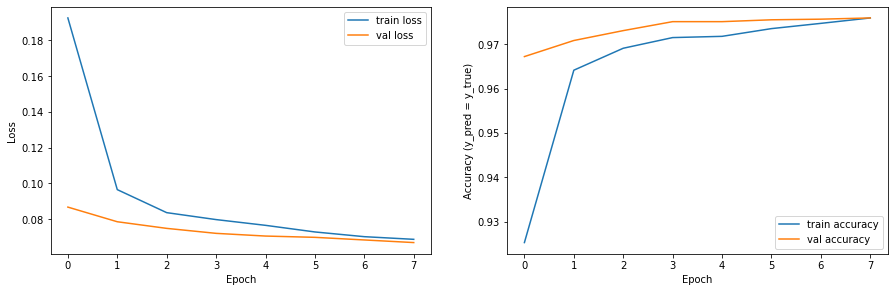

In [37]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [38]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

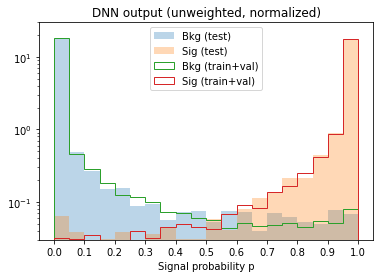

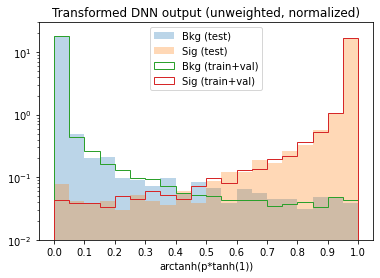

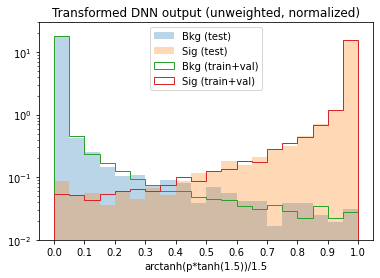

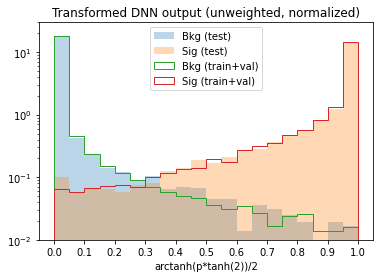

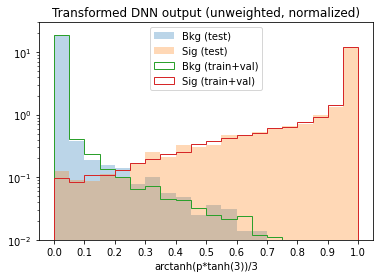

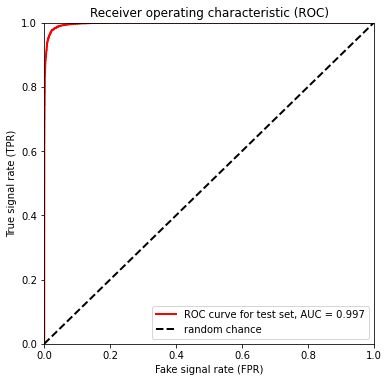

Test loss, test accuracy: [0.06591691572630806, 0.9754891991615295]


In [39]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(3e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1.5))/1.5')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 128)
print("Test loss, test accuracy:", results)

## Save trained model

In [40]:
joblib.dump(scaler, 'trained_models_rerunBtag/mt2b_scaler.gz')
model.save('trained_models_rerunBtag/mt2b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/mt2b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/mt2b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE, THE BELOW CAN BE IGNORED)

## Load all root files one by one

In [ ]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/mt18_raw/'
outfolder18 = 'root_outputs/mt18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('mutau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/mt17_raw/'
outfolder17 = 'root_outputs/mt17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('mutau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/mt16_raw/'
outfolder16 = 'root_outputs/mt16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('mutau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

## Feed to NN and write outputs to root files

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths16[i])